In this notebook we are utilizing textual data of various articles that are either truthfull and factual texts or fake news. As you will see most of the articles are political news. Given this set we will try to make a model that is able to classify fake and true articles.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Fake news

/content/drive/MyDrive/Fake news


In [ ]:
pip install optuna pytorch_lightning lime

In [ ]:
import zipfile
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
from sentence_transformers import SentenceTransformer
import optuna
import torch
import spacy
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import nn
import pytorch_lightning as pl
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from pytorch_lightning.loggers import CSVLogger
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.utils.class_weight import compute_class_weight
from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer
import joblib
from lime.lime_text import LimeTextExplainer

In [ ]:
from preprocessing.text_processing_and_feature_engineering import *

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
nlp = spacy.load("en_core_web_sm")

### Data splitting

Given the time aspect of the text in order to minimise information leakage from the text we will split our data based on the times stamp, we will evaluate data on the first 10% text for each validation and test and use remaining 80% for the training.

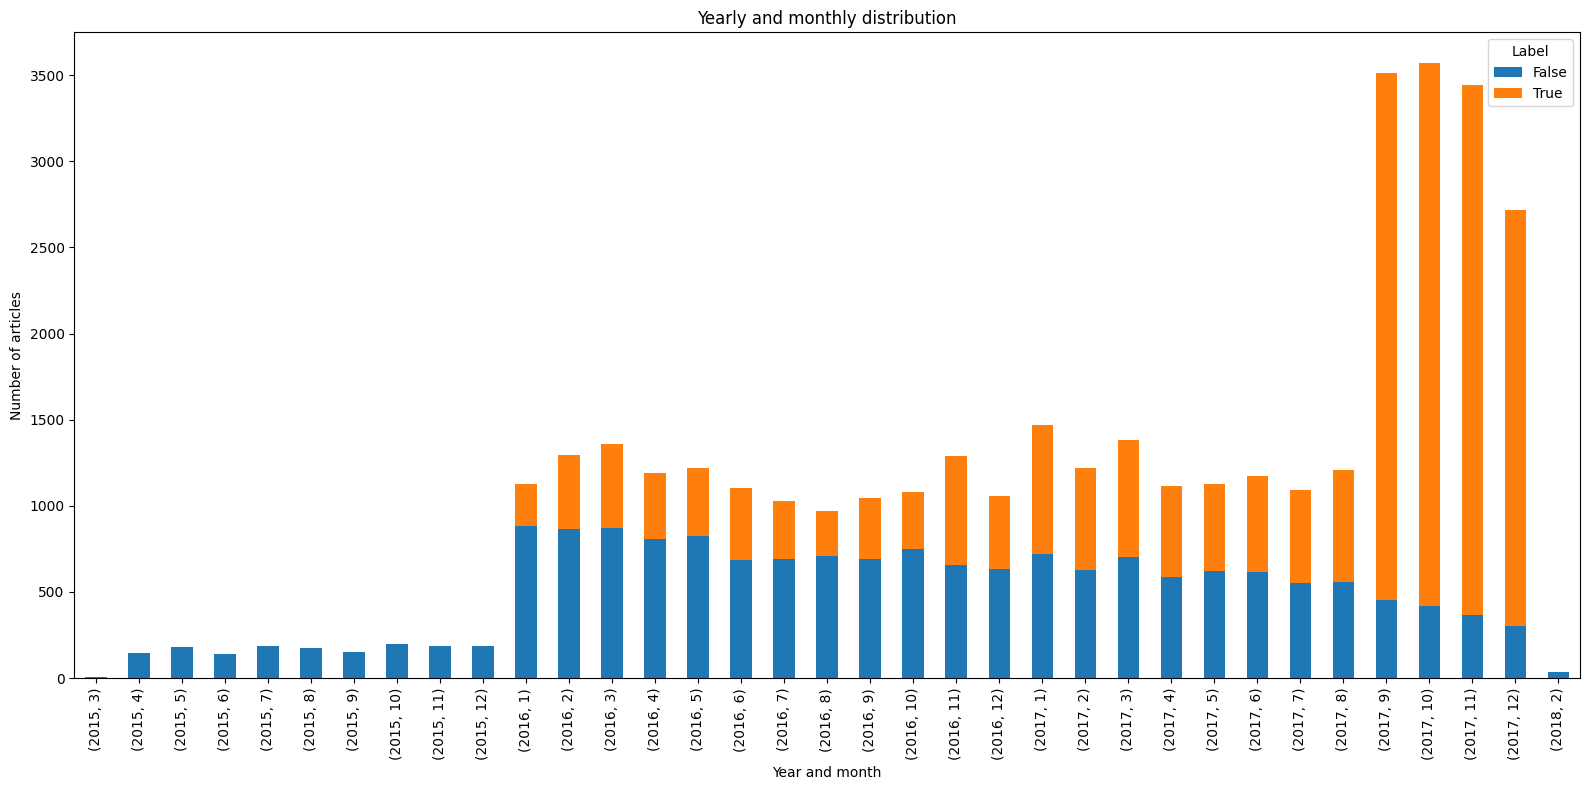

70% for training, 15% validation and test.

In [8]:
combined_data_copy = pd.read_csv("combined_data_cleaned.csv")

In [9]:
combined_data_copy = combined_data_copy.sort_values(by="date").reset_index(drop=True)

In [10]:
train_size = int(0.8 * len(combined_data_copy))
val_size = int(0.1 * len(combined_data_copy))

In [11]:
test_data = combined_data_copy.iloc[:val_size]  # earliest 15% for testing
val_data = combined_data_copy.iloc[val_size:val_size + val_size]  # following 15% for validation
train_data = combined_data_copy.iloc[val_size + val_size:]  # and remaining 70% for training

In [12]:
print(f"Train set: {len(train_data)} samples")
print(f"Validation set: {len(val_data)} samples")
print(f"Test set: {len(test_data)} samples")

Train set: 30698 samples
Validation set: 3837 samples
Test set: 3837 samples


In [13]:
print("Train set distribution:\n", train_data["label"].value_counts(normalize=True))
print("Validation set distribution:\n", val_data["label"].value_counts(normalize=True))
print("Test set distribution:\n", test_data["label"].value_counts(normalize=True))

Train set distribution:
 label
True     0.569027
False    0.430973
Name: proportion, dtype: float64
Validation set distribution:
 label
True     0.651029
False    0.348971
Name: proportion, dtype: float64
Test set distribution:
 label
False    0.68074
True     0.31926
Name: proportion, dtype: float64


We can see that training anad validation imbalance is similiar, however test set is complete opossite. It might be even a good thing, we will be able to compare validation and test results as see how these different imbalances in way had an effect.

### Feature engineering

We are basicing feature engineering on our findings from the EDA where we have explored each labels distributions based on these feature. Visually these features demonstrated significant differences that could be crucial for distinguishing between false and true texts.

In [16]:
train_df = preprocess_and_engineer_features(train_data)
val_df = preprocess_and_engineer_features(val_data)

/content/drive/MyDrive/Fake news/preprocessing/text_processing_and_feature_engineering.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["text"] = dataset["text"].str.strip()
/content/drive/MyDrive/Fake news/preprocessing/text_processing_and_feature_engineering.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["title"] = dataset["title"].str.strip()


### Embedding clustering.

Before proceeding with modeling we want to do an additional anomaly search using sentence embeddings with the all-MiniLM-L6-v2 transformer model. By clustering these embeddings into two groups using KMeans we explore how the labels are distributed across those clusters. This helps us identify potential anomalies or patterns in the data that might influence model performance.

In [16]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [17]:
train_embeddings = embedding_model.encode(train_df['cleaned_text'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/960 [00:00<?, ?it/s]

In [18]:
np.save("train_embeddings.npy", train_embeddings)

In [19]:
print(f"Train embeddings shape: {train_embeddings.shape}")

Train embeddings shape: (30698, 384)


In [20]:
n_clusters = 2

In [21]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

In [22]:
train_cluster_labels = kmeans.fit_predict(train_embeddings)

In [23]:
print(f"Cluster labels: {np.unique(train_cluster_labels)}")

Cluster labels: [0 1]


In [24]:
tsne = TSNE(n_components=2, random_state=42)

In [25]:
embeddings_2d = tsne.fit_transform(train_embeddings)

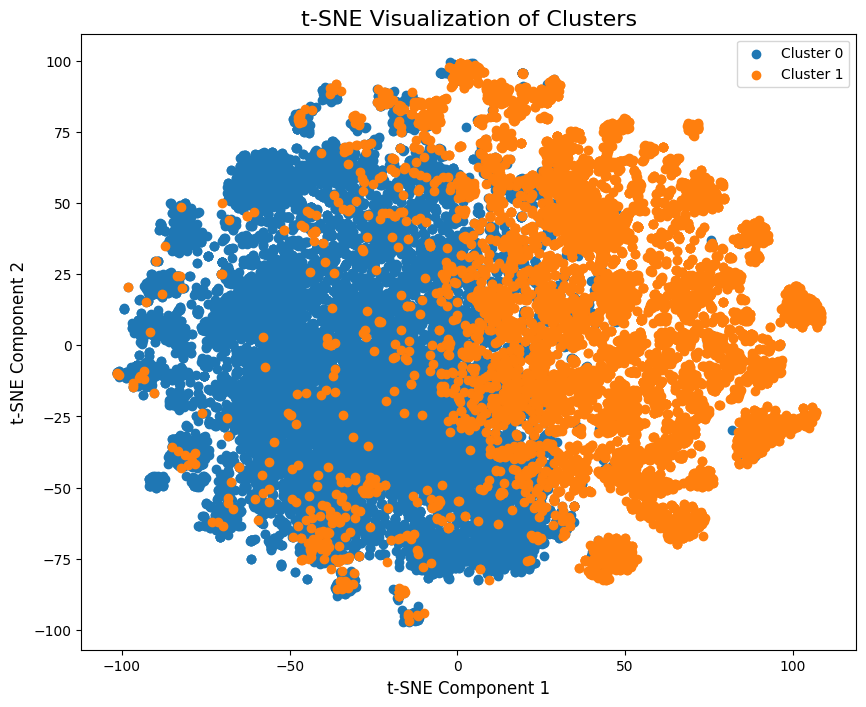

In [26]:
plt.figure(figsize=(10, 8))
for cluster in np.unique(train_cluster_labels):
    cluster_points = embeddings_2d[train_cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

plt.title("t-SNE Visualization of Clusters", fontsize=16)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend()
plt.show()

We observe some overlap between the clusters, as well as distinct differences, indicating that the features capture meaningful patterns while still having areas of ambiguity. We can't tell if there are any anomalies of the text that we should consider even removing.

In [27]:
train_df['cluster'] = train_cluster_labels

In [28]:
cluster_label_counts = train_df.groupby('cluster')['label'].value_counts()

In [29]:
print("Cluster and label distribution:")
print(cluster_label_counts)

Cluster and label distribution:
cluster  label
0        False    11779
         True      6978
1        True     10490
         False     1451
Name: count, dtype: int64


Cluster 1 contains a significant proportion of true labels compared to false, while cluster 0 shows a greater representation of false labels. To make embeddings more a like and not dependent on certain words we will do entity masking ans will see how it effects clusters.

Given our EDA results we have selected to make sure these entities are masked, this could be more extensive or more researched, this is based on our findings and some intuition what could potentially create bias in the model and we don't want model to base it predictions only on the source or person indicated but more on the semantic meaning.

In [30]:
known_entities = {
    "trump": "PERSON",
    "trumps": "PERSON",
    "donald trump": "PERSON",
    "donald": "PERSON",
    "reuters": "ORG",
    "white house": "ORG",
    "fox news": "ORG",
    "cnn": "ORG",
    "cnn news": "ORG",
    "cnn tv": "ORG",
    "twitter": "ORG",
    "twitter com": "ORG",
    "fox": "ORG",
    "fox news": "ORG",
    "wire": "ORG",
    "wire com": "ORG",
    "washington post": "ORG",
    "washington": "ORG"
}

In [31]:
def mask_entities_in_cleaned_text(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.text in known_entities:
            tokens.append(f"[{known_entities[token.text]}]")
        elif token.ent_type_ in {"PERSON", "ORG", "GPE", "DATE"}:
            tokens.append(f"[{token.ent_type_}]")
        else:
            tokens.append(token.lemma_)
    return " ".join(tokens)

In [32]:
train_df['processed_text'] = train_df['cleaned_text'].apply(mask_entities_in_cleaned_text)
train_df['processed_title'] = train_df['cleaned_title'].apply(mask_entities_in_cleaned_text)

In [33]:
output_file = "preprocessed_clean_train_data.csv"
train_df.to_csv(output_file, index=False)

Validation and test sets are going to be lemmatized, but not masked.

In [21]:
def preprocess_text(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        if not token.is_punct:
            tokens.append(token.lemma_.lower())
    return " ".join(tokens)

In [35]:
val_df["processed_text"] = val_df["cleaned_text"].apply(preprocess_text)
val_df["processed_title"] = val_df["cleaned_title"].apply(preprocess_text)

In [36]:
output_file = "preprocessed_clean_val_data.csv"
val_df.to_csv(output_file, index=False)

In [14]:
train_df_masked = pd.read_csv("preprocessed_clean_train_data.csv")
val_df_masked = pd.read_csv("preprocessed_clean_val_data.csv")

In [38]:
train_df_masked['processed_text_withoutstops'] = train_df_masked['processed_text'].apply(remove_stopwords)
val_df_masked['processed_text_withoutstops'] = val_df_masked['processed_text'].apply(remove_stopwords)

In [39]:
train_clean_embeddings = embedding_model.encode(train_df_masked['processed_text'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/960 [00:00<?, ?it/s]

In [40]:
np.save("train_clean_embeddings.npy", train_clean_embeddings)

In [41]:
print(f"Train embeddings shape: {train_clean_embeddings.shape}")

Train embeddings shape: (30698, 384)


In [42]:
n_clusters = 2

In [43]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

In [44]:
train_clean_cluster_labels = kmeans.fit_predict(train_clean_embeddings)

In [45]:
print(f"Cluster labels: {np.unique(train_clean_cluster_labels)}")

Cluster labels: [0 1]


In [46]:
tsne = TSNE(n_components=2, random_state=42)

In [47]:
embeddings_2d = tsne.fit_transform(train_clean_embeddings)

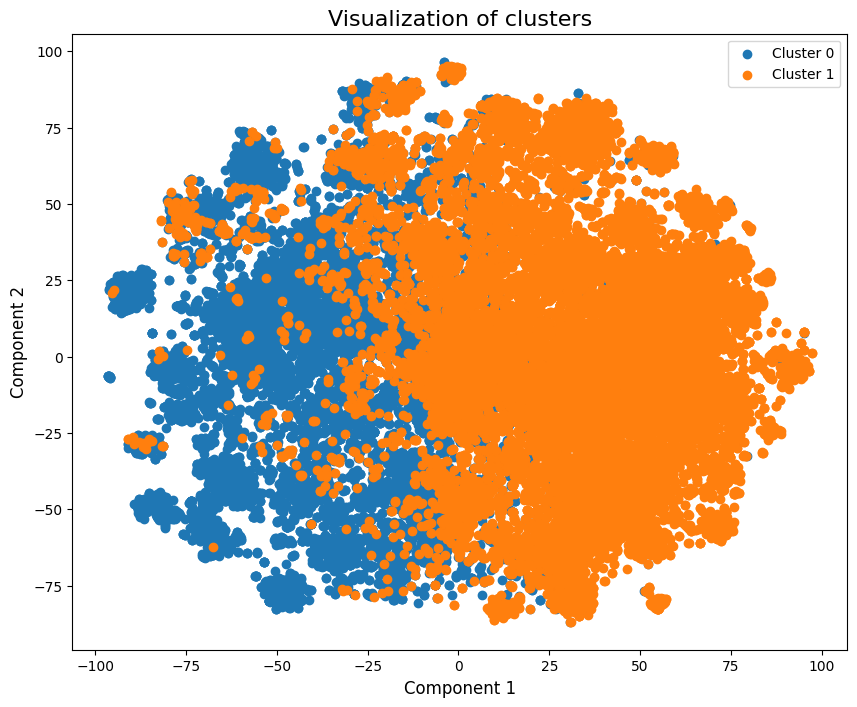

In [48]:
plt.figure(figsize=(10, 8))
for cluster in np.unique(train_clean_cluster_labels):
    cluster_points = embeddings_2d[train_clean_cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

plt.title("Visualization of clusters", fontsize=16)
plt.xlabel("Component 1", fontsize=12)
plt.ylabel("Component 2", fontsize=12)
plt.legend()
plt.show()

Clusters with masked entities shows a slightly different pattern compared to the unmasked data. While there is still overlap between the clusters masked entities appears to have affected the clustering boundaries a little potentially making them less distinct.

In [49]:
train_df_masked['cluster'] = train_clean_cluster_labels

In [50]:
for cluster in range(n_clusters):
    cluster_texts = train_df_masked[train_df_masked['cluster'] == cluster]['processed_text']
    all_words = " ".join(cluster_texts).split()
    top_words = Counter(all_words).most_common(10)
    print(f"Cluster {cluster} - Top Words: {top_words}")

Cluster 0 - Top Words: [('the', 266866), ('to', 147089), ('[GPE]', 142200), ('[ORG]', 138148), ('be', 136913), ('of', 123869), ('[PERSON]', 114041), ('and', 113553), ('[DATE]', 111719), ('in', 110771)]
Cluster 1 - Top Words: [('the', 364754), ('[PERSON]', 264679), ('be', 227116), ('to', 218882), ('[ORG]', 188615), ('of', 167612), ('a', 165981), ('and', 161966), ('in', 131250), ('[DATE]', 128052)]


In [51]:
cluster_label_counts = train_df_masked.groupby('cluster')['label'].value_counts()

In [52]:
print("Cluster and label distribution:")
print(cluster_label_counts)

Cluster and label distribution:
cluster  label
0        True     11269
         False     1802
1        False    11428
         True      6199
Name: count, dtype: int64


Entity masking does not appear to have significantly changed the cluster proportions. Interestingly the clusters with masked entities seem now slightly more concentrated even though masking may have reduced reliance on specific names or organizations it might have also introduced uniformity in the text structure and potentially increased semantic similarities.

Results of culstering without entity masking:



```
Cluster and label distribution:
cluster  label
0        False    11779
         True      6978
1        True     10490
         False     1451
Name: count, dtype: int64
```



First lets determine if we can classify text based on its characteristics. During the EDA we observed differences in the distributions of various text and title characteristics.

We will remove highly correlated features to avoid multicollinearity since we will be employing logistic regression for the classification. Given the binary classification task it is a good starting point.

In [53]:
train_df['numeric_label'] = train_df['label'].replace({'True': 1, 'False': 0}).astype(int)

In [54]:
val_df['numeric_label'] = val_df['label'].replace({'True': 1, 'False': 0}).astype(int)

In [55]:
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).copy()

In [56]:
columns_to_drop = ['month', 'year', 'cluster']
numeric_features = numeric_features.drop(columns=columns_to_drop, errors='ignore')

In [57]:
correlation_matrix = numeric_features.corr()

In [58]:
label_correlation = correlation_matrix['numeric_label'].drop('numeric_label')

In [59]:
correlation_threshold = 0.9

In [60]:
upper_tri = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

In [61]:
features_to_drop = set()

In [62]:
for column in upper_tri.columns:
    correlated_features = upper_tri.index[upper_tri[column] > correlation_threshold].tolist()

    if correlated_features:
        if column in correlated_features:
            correlated_features.remove(column)

        for feature in correlated_features:
            if label_correlation[feature] < label_correlation[column]:
                features_to_drop.add(feature)
            else:
                features_to_drop.add(column)

In [63]:
filtered_features = numeric_features.drop(columns=features_to_drop)

print(f"Features to drop: {features_to_drop}")
print(f"Remaining features: {filtered_features.columns.tolist()}")

Features to drop: {'sentence_count', 'capital_letters_ratio_text', 'title_unique_word_count', 'title_word_count', 'special_char_ratio', 'word_count', 'special_char_ratio_text', 'unique_word_count'}
Remaining features: ['char_count', 'title_char_count', 'question_mark_ratio', 'exclamation_mark_ratio', 'ellipses_ratio', 'url_count_ratio', 'comma_ratio', 'period_ratio', 'capital_letter_ratio', 'avg_word_length', 'avg_word_length_title', 'symbol_to_word_ratio', 'hashtag_ratio', 'at_ratio', 'quote_ratio', 'question_mark_count_text', 'exclamation_mark_count_text', 'ellipses_count_text', 'stop_word_count_title', 'stop_word_ratio_title', 'numeric_label']


Given that we have some features that are counts of specific characteristics we will scale these features to ensure they are on a similar range with mean 0 and standard deviation as 1.

In [64]:
scaler = StandardScaler()

In [65]:
filtered_features_scaled = scaler.fit_transform(filtered_features)

In [66]:
filtered_features_columns = [col for col in filtered_features.columns if col != 'numeric_label']

In [67]:
X_train_scaled = scaler.fit_transform(train_df[filtered_features_columns].values)
y_train_scaled = train_df['numeric_label'].values

In [68]:
X_val_scaled = scaler.transform(val_df[filtered_features_columns].values)
y_val_scaled = val_df['numeric_label'].values

In [69]:
print(f"X_train shape: {X_train_scaled.shape}, y_train shape: {y_train_scaled.shape}")
print(f"X_val shape: {X_val_scaled.shape}, y_val shape: {y_val_scaled.shape}")

X_train shape: (30698, 20), y_train shape: (30698,)
X_val shape: (3837, 20), y_val shape: (3837,)


In [70]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train_scaled)

LogisticRegression(max_iter=1000, random_state=42)

In [71]:
y_val_pred = log_reg.predict(X_val_scaled)

print("Validation performance:")
print(classification_report(y_val_scaled, y_val_pred))

Validation performance:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1339
           1       0.94      0.94      0.94      2498

    accuracy                           0.92      3837
   macro avg       0.91      0.91      0.91      3837
weighted avg       0.92      0.92      0.92      3837



Right away logistic regression model demonstrates good classification performance with an overall accuracy of 91% on validation set.
The precision and recall for both classes are not well balanced, however f1 score is 91% indicates the model performs equally well enough across both classes.

In [72]:
conf_matrix = confusion_matrix(y_val_scaled, y_val_pred)

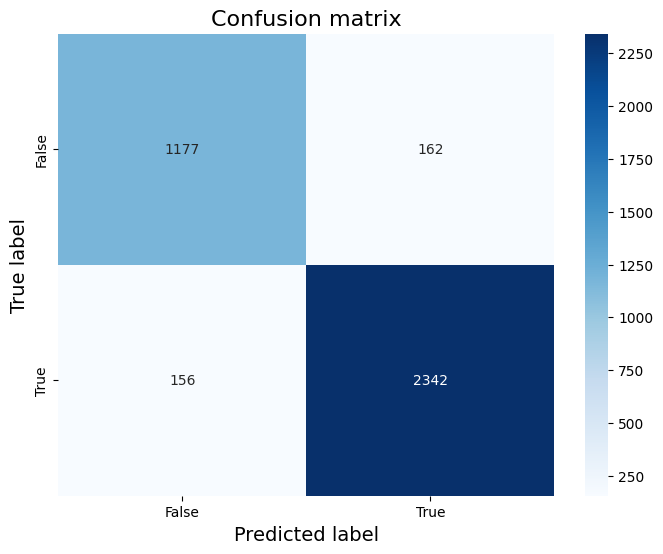

In [73]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.title("Confusion matrix", fontsize=16)
plt.xlabel("Predicted label", fontsize=14)
plt.ylabel("True label", fontsize=14)
plt.show()

The confusion matrix shows that the model correctly predicted 1177 false labels out of 1339 and 2342 true labels out of 2498.


In [74]:
y_val_prob = log_reg.predict_proba(X_val_scaled)[:, 1]
roc_auc = roc_auc_score(y_val_scaled, y_val_prob)

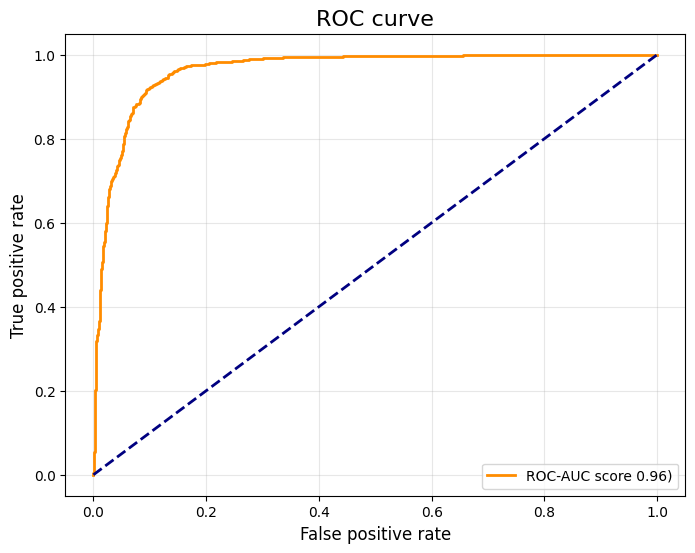

In [75]:
fpr, tpr, thresholds = roc_curve(y_val_scaled, y_val_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC-AUC score {roc_auc:.2f})", color="darkorange", lw=2)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False positive rate", fontsize=12)
plt.ylabel("True positive rate", fontsize=12)
plt.title("ROC curve", fontsize=16)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

ROC-AUC score 0.96 shows that the model is very capable of distinguishing between the false and true classes.

In [76]:
feature_importance = pd.DataFrame({
    'Features': filtered_features_columns,
    'Coefficients': log_reg.coef_[0]
}).sort_values(by='Coefficients', ascending=False)

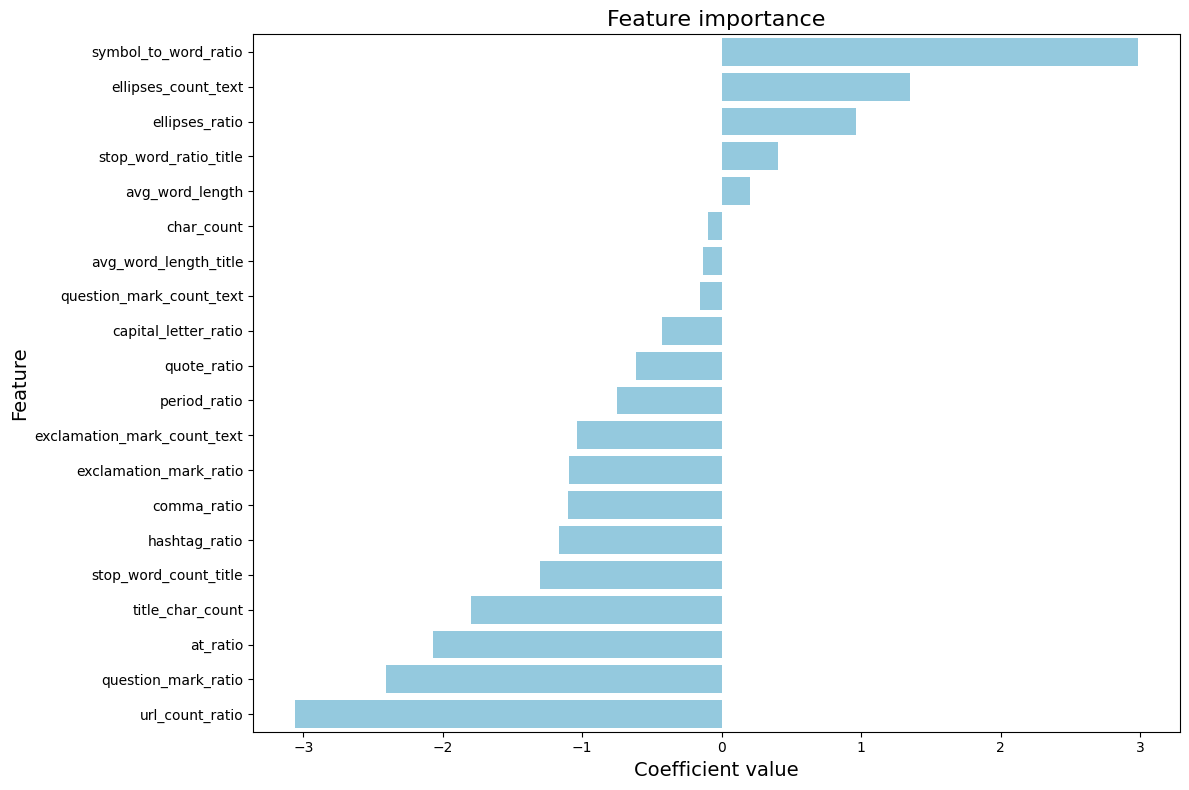

In [77]:
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance, x='Coefficients', y='Features', color="skyblue", orient='h')
plt.title("Feature importance", fontsize=16)
plt.xlabel("Coefficient value", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()

Symbol to word ratio and ellipses count in text are the 2 top positive contributors to the predictions of true articles. Features like stop word ratio of title and average word length also positively contribute.Negative coefficients like URL count ratio and question mark ratio shows these features are more indicative of false articles.

**RFE**

To find the most impactful features for classification we used recursive feature elimination method using logistic regression. It iteratively removes least important features based on the coefficients, this simplifies feature space but could maintain performance. We will leave 14 features from 20 and will see how it changes the performance.

In [78]:
log_reg_rfe = LogisticRegression(max_iter=1000, random_state=42)

In [79]:
rfe = RFE(estimator=log_reg_rfe, n_features_to_select=14, step=1)

In [80]:
rfe.fit(X_train_scaled, y_train_scaled)

RFE(estimator=LogisticRegression(max_iter=1000, random_state=42),
    n_features_to_select=14)

In [81]:
rfe_ranking = pd.DataFrame({
    'Feature': filtered_features_columns,
    'Rankings': rfe.ranking_
}).sort_values(by='Rankings')

In [82]:
selected_features = rfe_ranking[rfe_ranking['Rankings'] == 1]['Feature'].tolist()
print(f"Selected features: {selected_features}")

Selected features: ['title_char_count', 'question_mark_ratio', 'exclamation_mark_ratio', 'ellipses_ratio', 'comma_ratio', 'url_count_ratio', 'period_ratio', 'symbol_to_word_ratio', 'at_ratio', 'quote_ratio', 'hashtag_ratio', 'exclamation_mark_count_text', 'ellipses_count_text', 'stop_word_count_title']


In [83]:
X_train_rfe = rfe.transform(X_train_scaled)
X_val_rfe = rfe.transform(X_val_scaled)

In [84]:
log_reg_rfe.fit(X_train_rfe, y_train_scaled)

LogisticRegression(max_iter=1000, random_state=42)

In [85]:
y_val_pred_rfe = log_reg_rfe.predict(X_val_rfe)

In [86]:
print(classification_report(y_val_scaled, y_val_pred_rfe))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1339
           1       0.93      0.94      0.93      2498

    accuracy                           0.92      3837
   macro avg       0.91      0.91      0.91      3837
weighted avg       0.92      0.92      0.92      3837



Performance seems to be remaining the same.

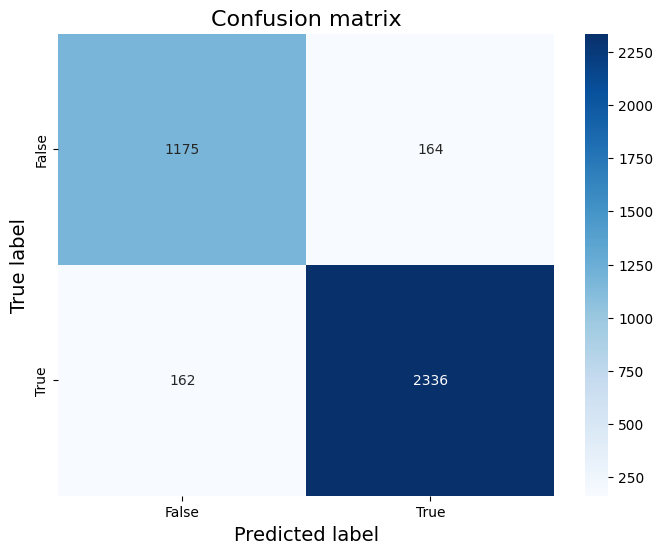

In [87]:
conf_matrix_rfe = confusion_matrix(y_val_scaled, y_val_pred_rfe)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rfe, annot=True, fmt="d", cmap="Blues", xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.title("Confusion matrix", fontsize=16)
plt.xlabel("Predicted label", fontsize=14)
plt.ylabel("True label", fontsize=14)
plt.show()

With 14 variables instead of 20 we have few misclassifications, 2 more false positives and 6 more false negatives. Previous model confusion matrix:

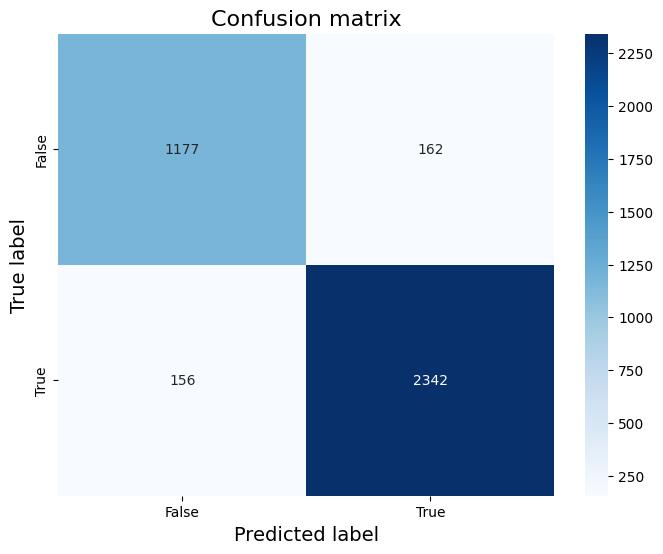

In [88]:
y_val_prob_rfe = log_reg_rfe.predict_proba(X_val_rfe)[:, 1]
roc_auc_rfe = roc_auc_score(y_val_scaled, y_val_prob_rfe)

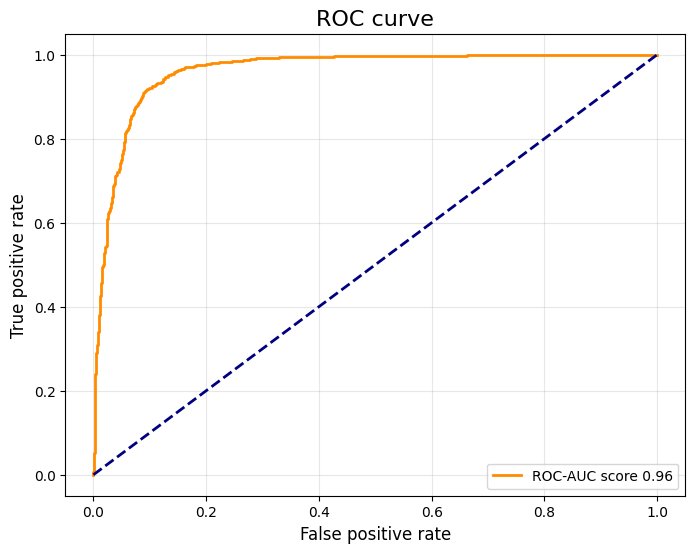

In [89]:
fpr_rfe, tpr_rfe, thresholds_rfe = roc_curve(y_val_scaled, y_val_prob_rfe)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rfe, tpr_rfe, label=f"ROC-AUC score {roc_auc_rfe:.2f}", color="darkorange", lw=2)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False positive rate", fontsize=12)
plt.ylabel("True positive rate", fontsize=12)
plt.title("ROC curve", fontsize=16)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

ROC-AUC shows the same results as before.

In [90]:
feature_importance_rfe = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': log_reg_rfe.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

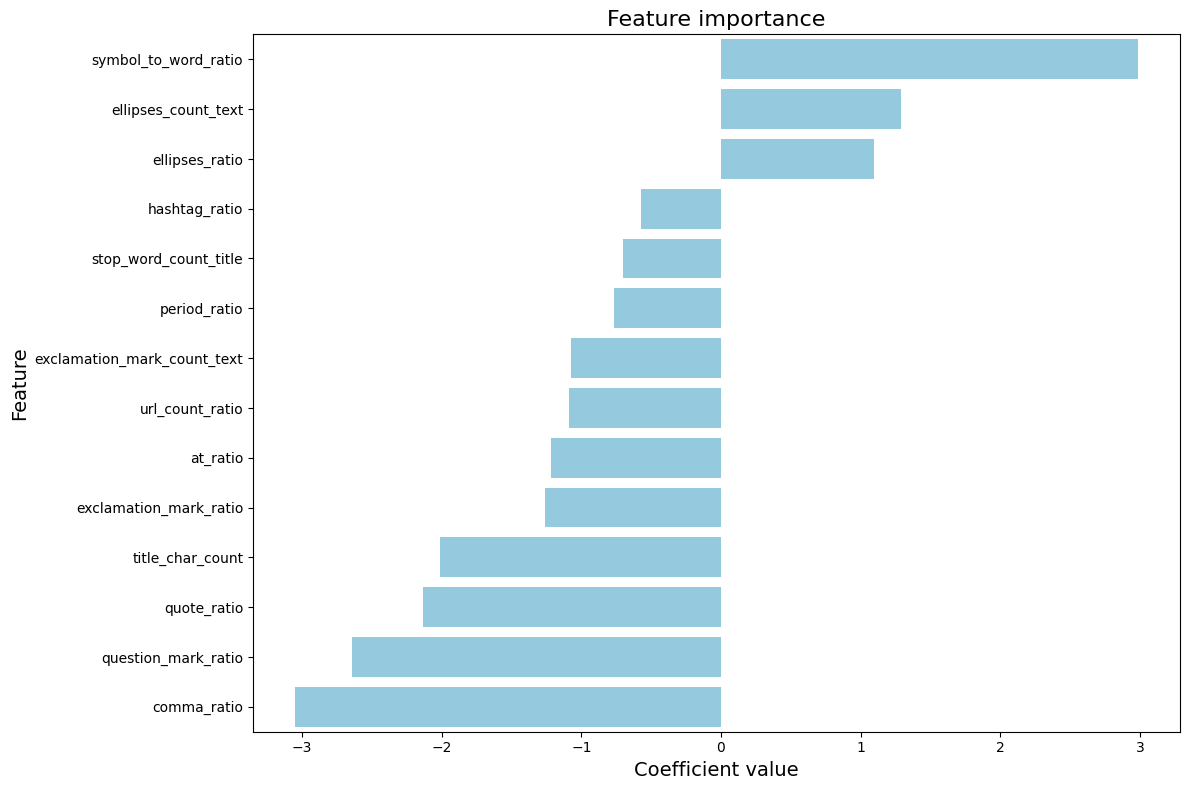

In [91]:
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_rfe, x='Coefficient', y='Feature', color="skyblue", orient='h')
plt.title("Feature importance", fontsize=16)
plt.xlabel("Coefficient value", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()

Symbol to word ratio and ellipses count remained the most positively effecting features.

Interestingly features like question mark ratio and comma ratio have higher negative impact compared to the features impact from previous model where url count ration was most siginificant:

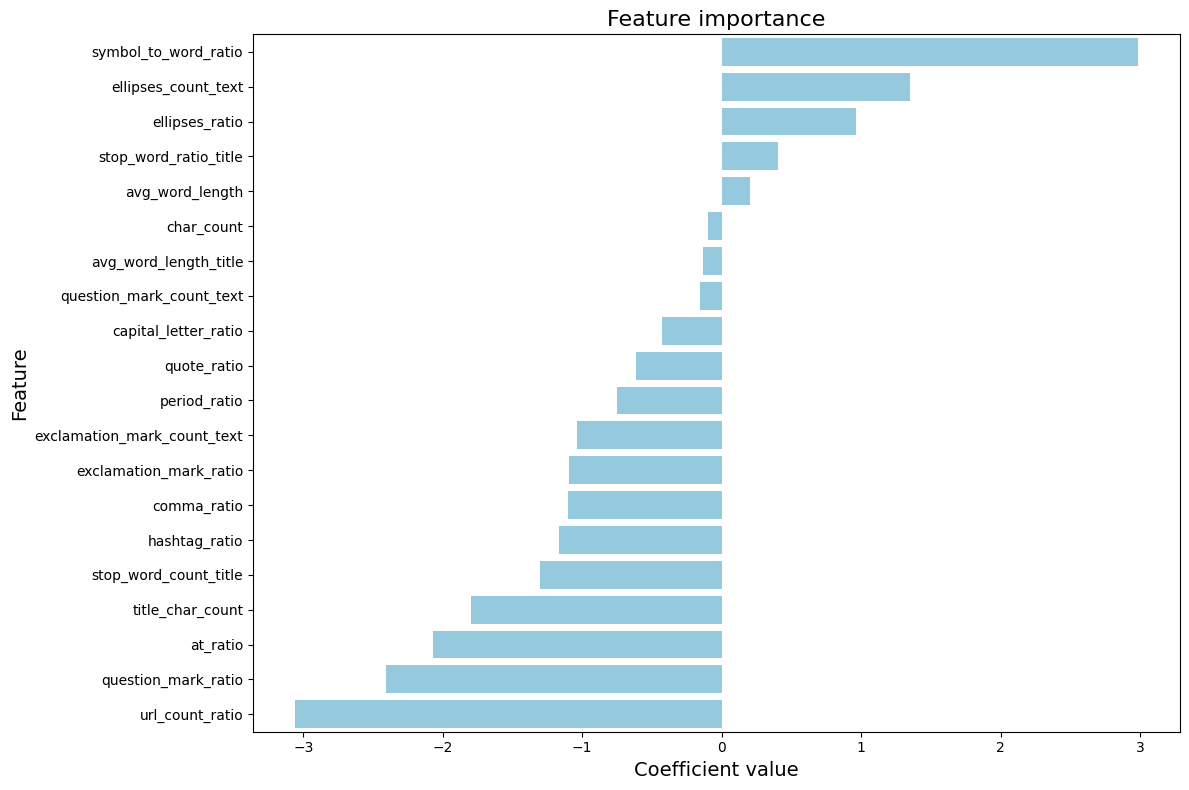

####  Adding class weights

 We incorporated class weights into the logistic regression model with class_weight=balanced making weights inversely proportional to class proportions.

In [92]:
log_reg_weighted = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

In [93]:
log_reg_weighted.fit(X_train_rfe, y_train_scaled)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [94]:
y_val_pred_weighted = log_reg_weighted.predict(X_val_rfe)

In [95]:
print(classification_report(y_val_scaled, y_val_pred_weighted))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1339
           1       0.95      0.92      0.93      2498

    accuracy                           0.91      3837
   macro avg       0.90      0.91      0.91      3837
weighted avg       0.92      0.91      0.91      3837



General results are remaining similiar with accurcy and f1 score 90% and 91% accordingly. True articles with class weights introduced got better precission and false texts increased recall score compared to the models performance before:



```
  precision    recall  f1-score   support

           0       0.88      0.88      0.88      1339
           1       0.93      0.94      0.93      2498

    accuracy                           0.92      3837
   macro avg       0.91      0.91      0.91      3837
weighted avg       0.92      0.92      0.92      3837
```



In [96]:
y_val_prob_weighted = log_reg_weighted.predict_proba(X_val_rfe)[:, 1]
roc_auc_weighted = roc_auc_score(y_val_scaled, y_val_prob_weighted)

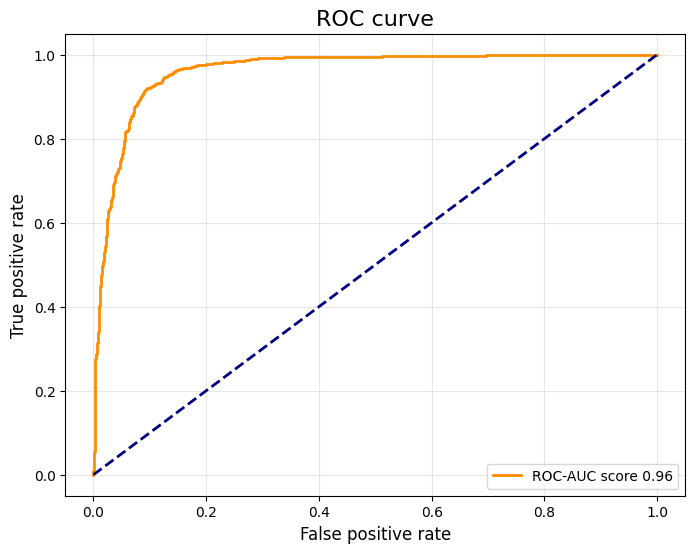

In [97]:
fpr_weighted, tpr_weighted, thresholds_weighted = roc_curve(y_val_scaled, y_val_prob_weighted)
plt.figure(figsize=(8, 6))
plt.plot(fpr_weighted, tpr_weighted, label=f"ROC-AUC score {roc_auc_weighted:.2f}", color="darkorange", lw=2)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False positive rate", fontsize=12)
plt.ylabel("True positive rate", fontsize=12)
plt.title("ROC curve", fontsize=16)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [98]:
feature_importance_weighted = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': log_reg_weighted.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

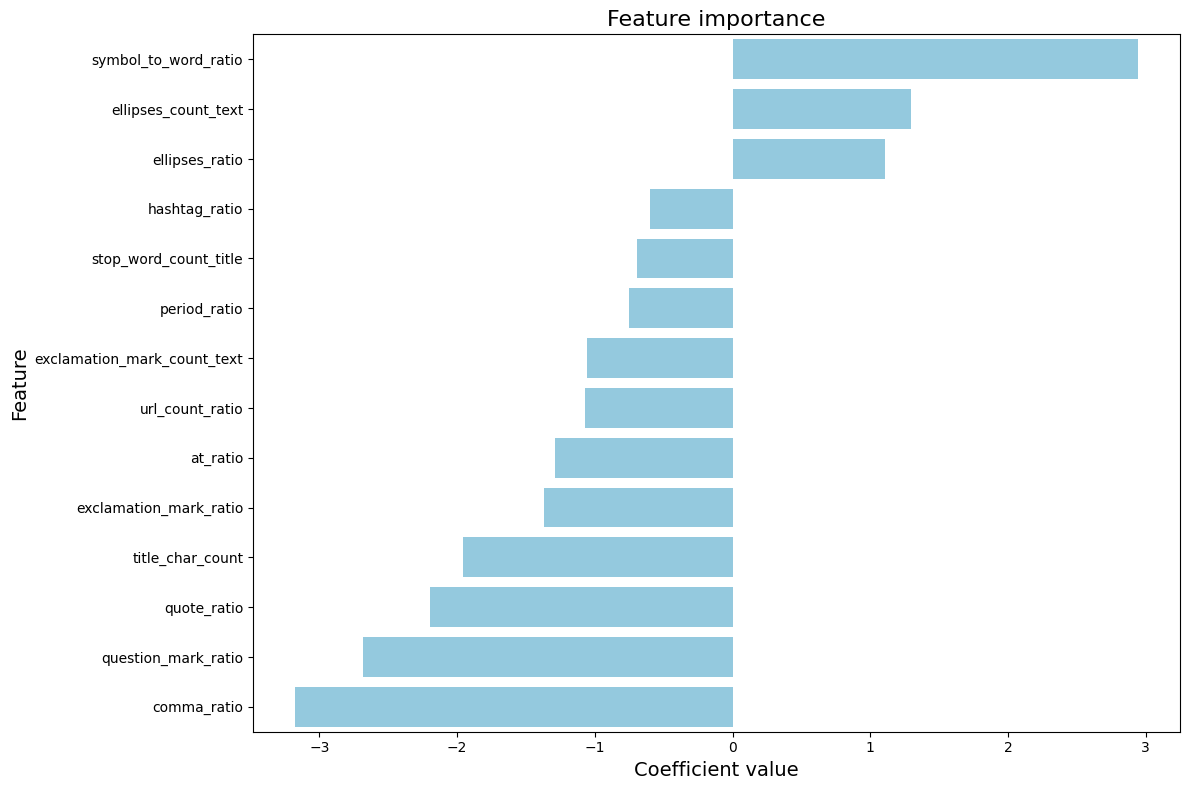

In [99]:
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_weighted, x='Coefficient', y='Feature', color="skyblue", orient='h')
plt.title("Feature importance", fontsize=16)
plt.xlabel("Coefficient value", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()

Neither ROC-AUC nor feature importance show any differences.

Since the hyperparameters were selected randomly before the results may not be improving due to our poor selection. We will use optuna for hyperparameter tuning.

In [100]:
def objective(trial):
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    C = trial.suggest_loguniform("C", 1e-4, 1e4)
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])

    model = LogisticRegression(
        max_iter=1000,
        random_state=42,
        penalty=penalty,
        solver="liblinear" if penalty == "l1" else "lbfgs",
        C=C,
        class_weight=class_weight,
    )

    scores = cross_val_score(model, X_train_rfe, y_train_scaled, cv=5, scoring="roc_auc")

    return scores.mean()

In [101]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, n_jobs=-1)

print("Best hyperparameters:", study.best_params)
print("Best score:", study.best_value)

[I 2025-01-20 08:37:46,447] A new study created in memory with name: no-name-2dad5ca8-8602-40d8-bdfa-49e2c1a6748f
<ipython-input-100-8b02c9368a88>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-4, 1e4)
<ipython-input-100-8b02c9368a88>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-4, 1e4)
<ipython-input-100-8b02c9368a88>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-4, 1e4)
<ipython-input-100-8b0

Best hyperparameters: {'penalty': 'l2', 'C': 1548.1523762330326, 'class_weight': 'balanced'}
Best score: 0.9708385570942267


In [102]:
best_params = study.best_params

In [103]:
best_log_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    penalty=best_params["penalty"],
    solver="liblinear" if best_params["penalty"] == "l1" else "lbfgs",
    C=best_params["C"],
    class_weight=best_params["class_weight"],
)

In [104]:
best_log_model.fit(X_train_rfe, y_train_scaled)

LogisticRegression(C=1548.1523762330326, class_weight='balanced', max_iter=1000,
                   random_state=42)

In [105]:
y_val_pred_best = best_log_model.predict(X_val_rfe)

In [106]:
print(classification_report(y_val_scaled, y_val_pred_best))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1339
           1       0.95      0.92      0.93      2498

    accuracy                           0.91      3837
   macro avg       0.90      0.91      0.91      3837
weighted avg       0.92      0.91      0.91      3837



Results are identical after hyperparameters tuning.

In [107]:
conf_matrix_best = confusion_matrix(y_val_scaled, y_val_pred_best)

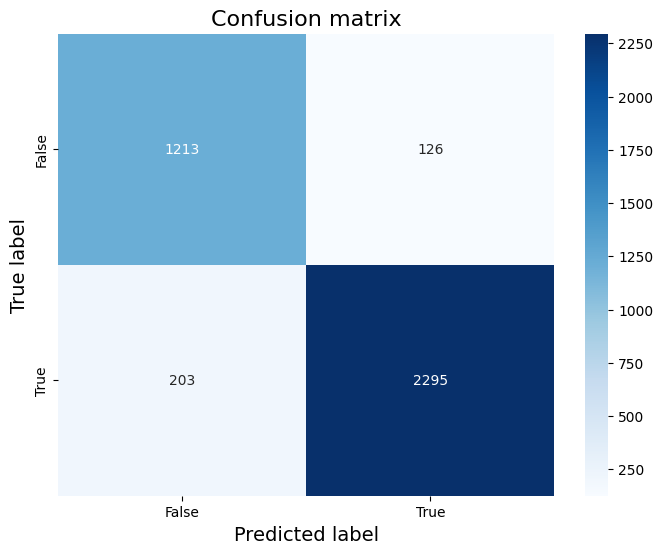

In [108]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Blues", xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.title("Confusion matrix", fontsize=16)
plt.xlabel("Predicted label", fontsize=14)
plt.ylabel("True label", fontsize=14)
plt.show()

In [109]:
y_val_prob_best = best_log_model.predict_proba(X_val_rfe)[:, 1]
roc_auc_best = roc_auc_score(y_val_scaled, y_val_prob_best)

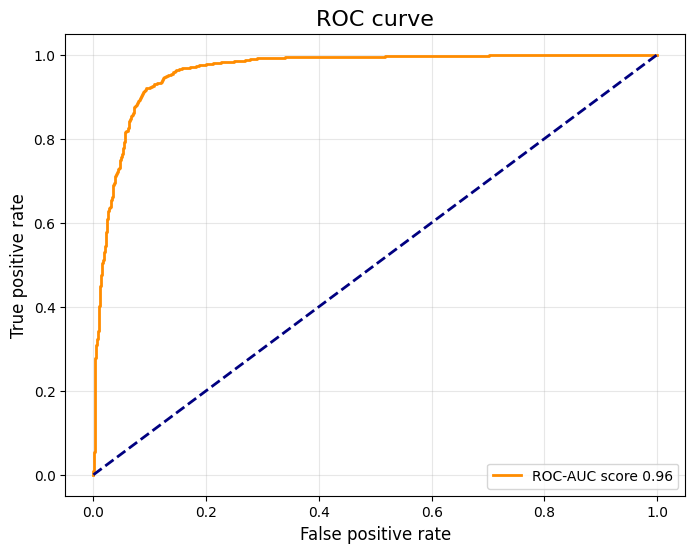

In [110]:
fpr_best, tpr_best, thresholds_best = roc_curve(y_val_scaled, y_val_prob_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr_best, tpr_best, label=f"ROC-AUC score {roc_auc_best:.2f}", color="darkorange", lw=2)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False positive rate", fontsize=12)
plt.ylabel("True positive rate", fontsize=12)
plt.title("ROC curve", fontsize=16)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [111]:
feature_importance_best = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': best_log_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

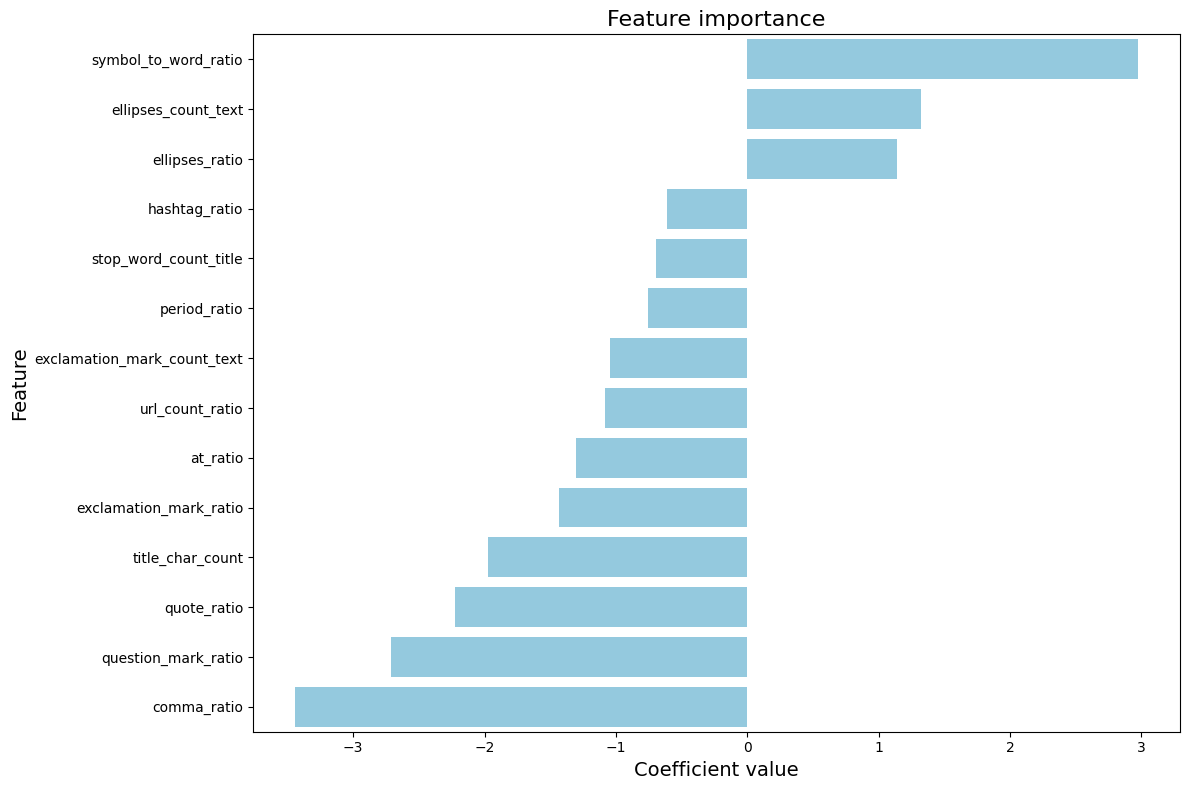

In [112]:
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_best, x='Coefficient', y='Feature', color="skyblue", orient='h')
plt.title("Feature importance", fontsize=16)
plt.xlabel("Coefficient value", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()

Results remained almost identical after hyperparameters tuning.

In [113]:
model_dir = "logistic_regression_model"
os.makedirs(model_dir, exist_ok=True)

In [114]:
model_path = os.path.join(model_dir, "logistic_regression_model.pkl")
scaler_path = os.path.join(model_dir, "scaler.pkl")

In [115]:
joblib.dump(best_log_model, model_path)
joblib.dump(scaler, scaler_path)

['logistic_regression_model/scaler.pkl']

### Evaluating logistic regression on the test set

In [116]:
from logistic_regression_model import LogisticRegressionEvaluationPipeline

In [117]:
pipeline = LogisticRegressionEvaluationPipeline(model_dir="logistic_regression_model")

/content/drive/MyDrive/Fake news/preprocessing/text_processing_and_feature_engineering.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["text"] = dataset["text"].str.strip()
/content/drive/MyDrive/Fake news/preprocessing/text_processing_and_feature_engineering.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["title"] = dataset["title"].str.strip()
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted 

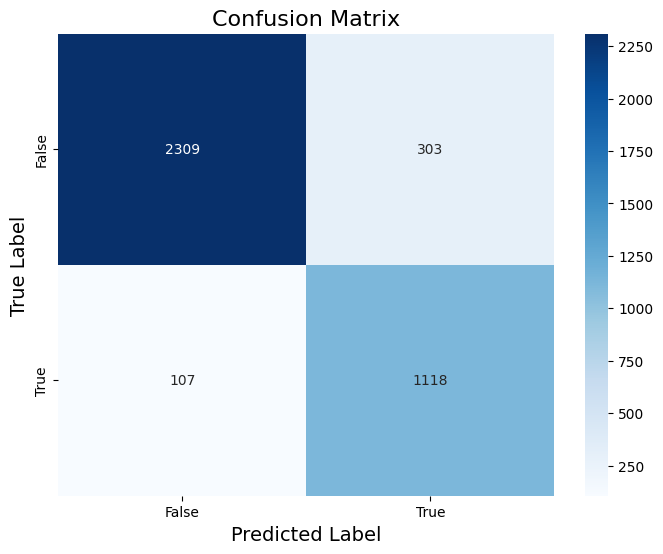

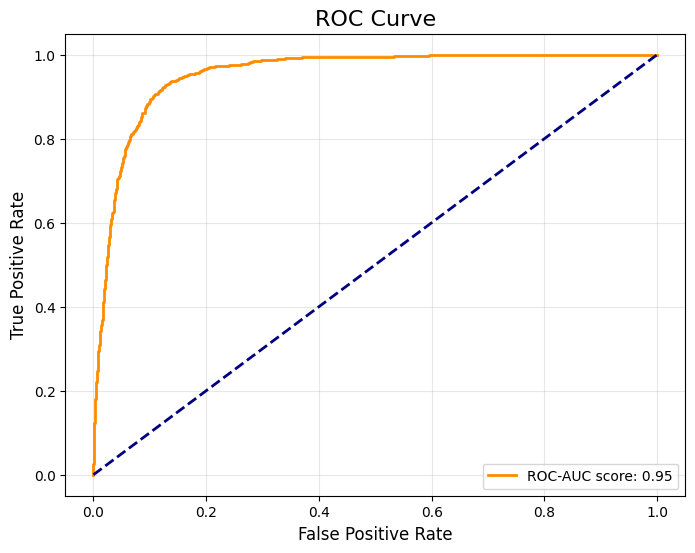

In [118]:
results = pipeline.evaluate(test_data, test_data["label"])

In [ ]:
print(results["classification_report"])
print("ROC-AUC:", results["roc_auc"])

              precision    recall  f1-score   support

       False       0.96      0.88      0.92      2612
        True       0.79      0.91      0.85      1225

    accuracy                           0.89      3837
   macro avg       0.87      0.90      0.88      3837
weighted avg       0.90      0.89      0.90      3837

ROC-AUC: 0.9546088695815232


We know that test set's distribution is bit different compared to train and validation, in test set we have higher number of false articles. Despite that we can see that model is doing well enough. ROC-AUC score almost did not change 0.95 compared to 0.96 that we got from validations data. 87% and 88% for accurancy and f1 score.

In this part we will use TF-IDF embeddings to represent the masked entity training data and evaluate its performance using logistic regression on the unmasked validation set that we have created during clusttering excersise. We are combining processed text and titles which are masked into a one input. For TF-IDF we will use 500 features.

In [119]:
train_df_masked['combined'] = train_df_masked['processed_text'] + " " + train_df_masked['processed_title']
val_df_masked['combined'] = val_df_masked['processed_text'] + " " + val_df_masked['processed_title']

In [120]:
tfidf_vectorizer = TfidfVectorizer(max_features=500)

In [121]:
X_train_tf = tfidf_vectorizer.fit_transform(train_df_masked['combined'])
X_val_tf = tfidf_vectorizer.transform(val_df_masked['combined'])

In [123]:
y_train_tf = train_df_masked['label'].replace({"True": 1, "False": 0}).values
y_val_tf = val_df_masked['label'].replace({"True": 1, "False": 0}).values

In [124]:
logistic_model_tf = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', class_weight='balanced', random_state=42)

In [125]:
logistic_model_tf.fit(X_train_tf, y_train_tf)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [126]:
y_val_pred = logistic_model_tf.predict(X_val_tf)
y_val_prob = logistic_model_tf.predict_proba(X_val_tf)[:, 1]

In [127]:
print("Validation performance:")
print(classification_report(y_val_tf, y_val_pred))

Validation performance:
              precision    recall  f1-score   support

       False       0.91      0.98      0.94      1339
        True       0.99      0.95      0.97      2498

    accuracy                           0.96      3837
   macro avg       0.95      0.96      0.95      3837
weighted avg       0.96      0.96      0.96      3837



The logistic regression model using TF-IDF scores achieved better results compared to the engineered features model with 95% accuracy and F1 score. However despite the masking of entities model might overly rely on specific words. This could limit its generalizability and effectiveness in real life scenarios involving text that differs from political news. This model can definetely be compared with data that is outside this data set that we have been working on and only then we can rely on the results because method here might be not the most suitable to detect semantic patterns of false texts.

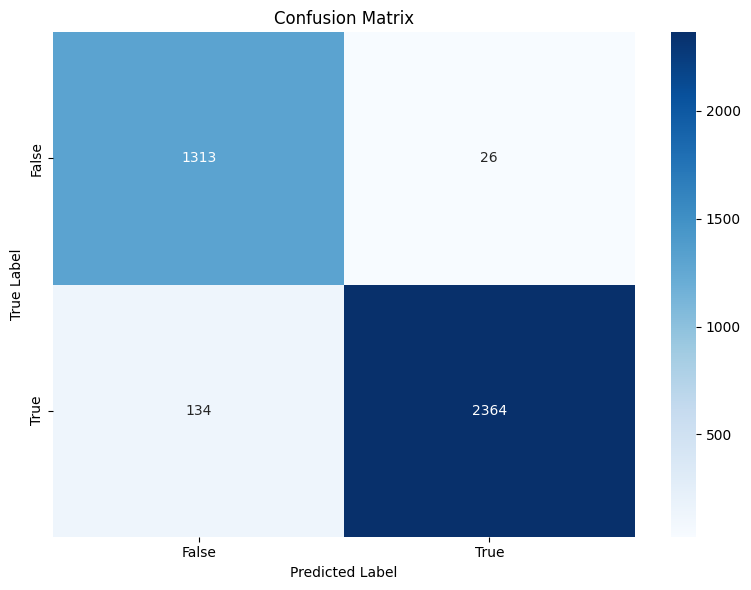

In [128]:
conf_matrix = confusion_matrix(y_val_tf, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

The model correctly identifies a large proportion of both labels. Most errors are concentrated in true labels.

In [129]:
fpr, tpr, thresholds = roc_curve(y_val_tf, y_val_prob)
roc_auc = roc_auc_score(y_val_tf, y_val_prob)

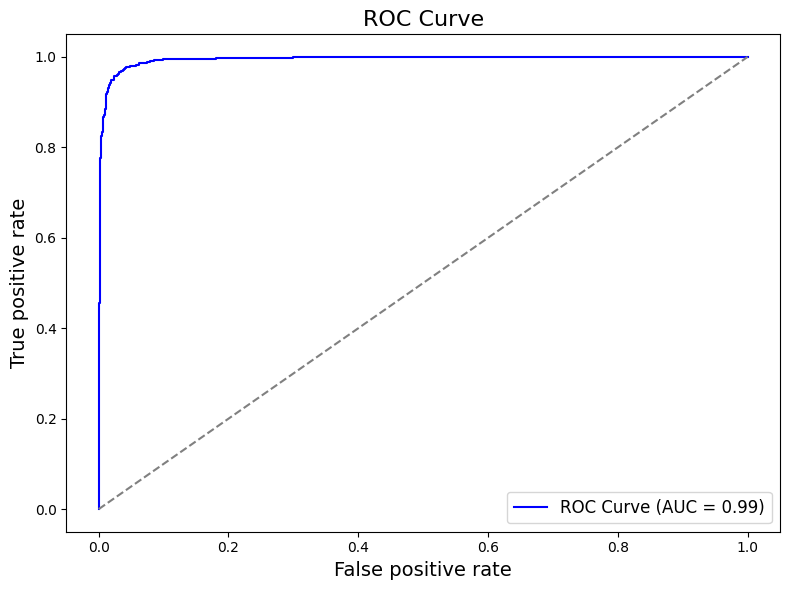

In [130]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.title("ROC Curve", fontsize=16)
plt.xlabel("False positive rate", fontsize=14)
plt.ylabel("True positive rate", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.show()

The model achieves 0.99 ROC-AUC score.

In [131]:
feature_importance = pd.DataFrame({
    'Feature': tfidf_vectorizer.get_feature_names_out(),
    'Coefficient': logistic_model_tf.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

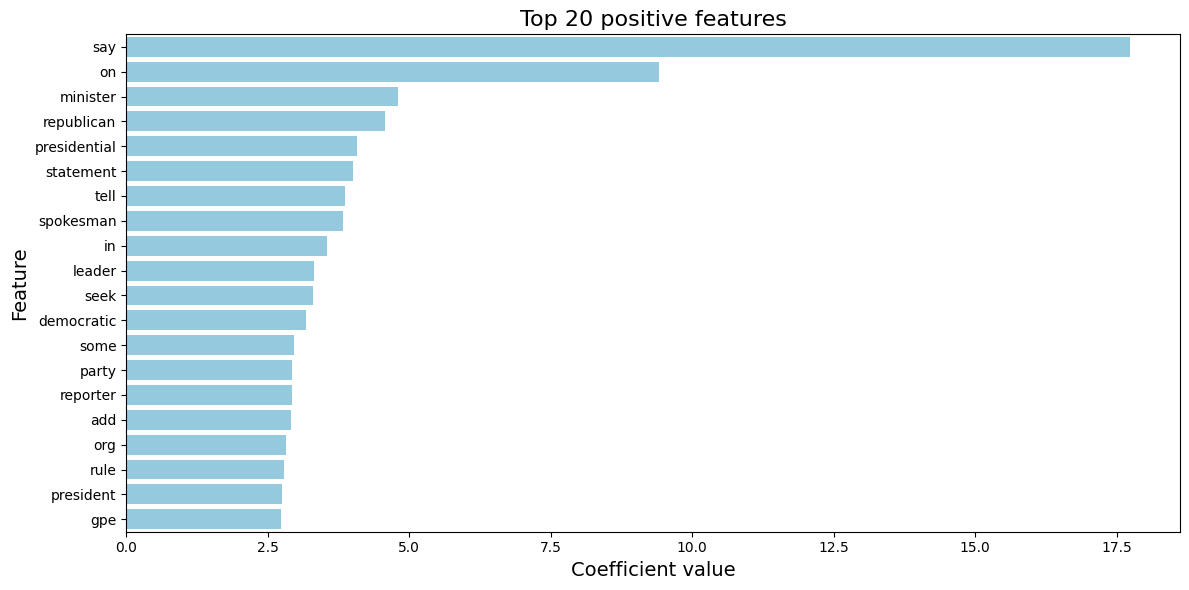

In [132]:
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(20), x='Coefficient', y='Feature', color="skyblue", orient='h')
plt.title("Top 20 positive features", fontsize=16)
plt.xlabel("Coefficient value", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()

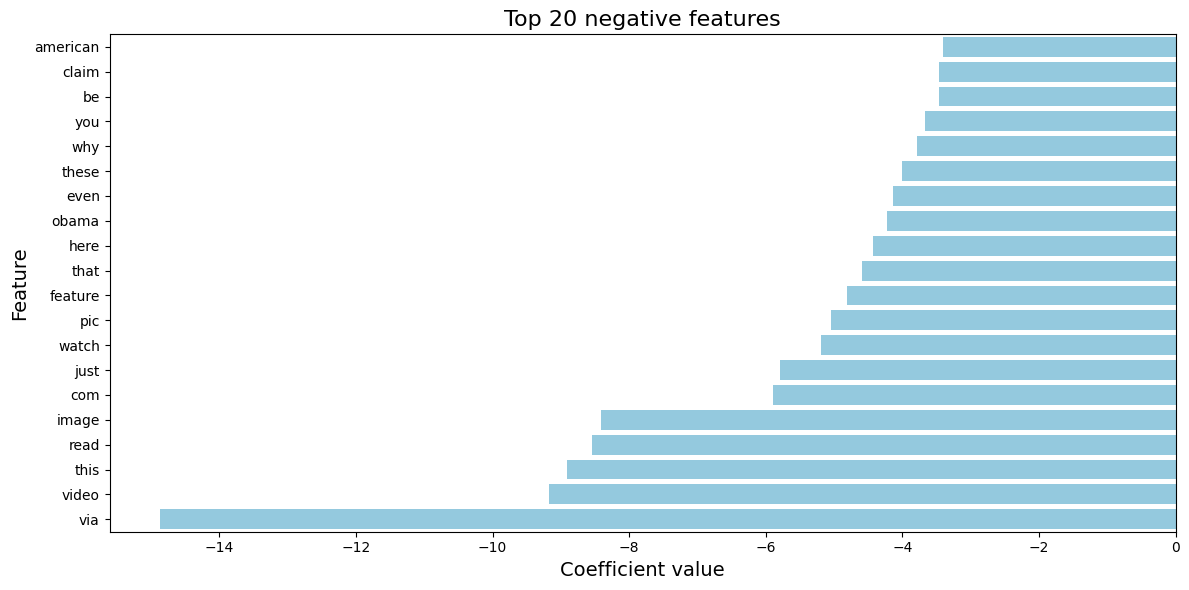

In [133]:
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.tail(20), x='Coefficient', y='Feature', color="skyblue", orient='h')
plt.title("Top 20 negative features", fontsize=16)
plt.xlabel("Coefficient value", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()

Words like say, on, republican and minister have highest positive coefficients showing strong association with the true articles. Words like via, video, read and image shows strongest association with false texts.


As mentioned before we don't think tf-idf embeddings based logistic regression model will be able to capture off topic articles well enough. This excerise was done out of interest to see which specific words in which class plays most significant role.

#### Random forest

To explore more engineered features we will try to use random forest classifier with them. This will increase complexity of the model, but might improve our results with sligh elevation of complexity and interpretability.

In [134]:
engineered_features = [
    'char_count', 'word_count', 'unique_word_count', 'avg_word_length', 'sentence_count',
    'symbol_to_word_ratio', 'capital_letter_ratio', 'special_char_ratio', 'comma_ratio',
    'period_ratio', 'question_mark_ratio', 'exclamation_mark_ratio', 'ellipses_ratio',
    'url_count_ratio', 'hashtag_ratio', 'at_ratio', 'quote_ratio', 'title_char_count',
    'title_word_count', 'title_unique_word_count', 'avg_word_length_title',
    'stop_word_count_title', 'stop_word_ratio_title'
]

In [135]:
X_train = train_df[engineered_features].fillna(0).values
y_train = train_df['numeric_label'].values

In [136]:
X_val = val_df[engineered_features].fillna(0).values
y_val = val_df['numeric_label'].values

In [137]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (30698, 23), y_train shape: (30698,)
X_val shape: (3837, 23), y_val shape: (3837,)


In [138]:
def random_forest_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 100)
    max_depth = trial.suggest_int("max_depth", 10, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        class_weight="balanced"
    )

    scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring="roc_auc")
    return scores.mean()

In [139]:
rf_study = optuna.create_study(direction="maximize")
rf_study.optimize(random_forest_objective, n_trials=10, n_jobs=-1)

[I 2025-01-20 08:45:37,232] A new study created in memory with name: no-name-85a27d25-8957-4472-8dea-eab01356e6b3
[I 2025-01-20 08:46:00,564] Trial 8 finished with value: 0.9799605579457955 and parameters: {'n_estimators': 50, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 8 with value: 0.9799605579457955.
[I 2025-01-20 08:46:02,333] Trial 1 finished with value: 0.9801316602242185 and parameters: {'n_estimators': 51, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.9801316602242185.
[I 2025-01-20 08:46:06,665] Trial 4 finished with value: 0.980234114550278 and parameters: {'n_estimators': 63, 'max_depth': 37, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.980234114550278.
[I 2025-01-20 08:46:07,816] Trial 3 finished with value: 0.9796547276764297 and parameters: {'n_estimators': 80, 'max_depth': 26, 'min_sam

In [140]:
best_params = rf_study.best_params
print("Best hyperparameters:", best_params)

Best hyperparameters: {'n_estimators': 82, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


In [141]:
best_rf_model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features"],
    random_state=42,
    class_weight="balanced"
)

In [142]:
best_rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=24,
                       min_samples_split=3, n_estimators=82, random_state=42)

In [143]:
y_val_pred = best_rf_model.predict(X_val)
y_val_prob = best_rf_model.predict_proba(X_val)[:, 1]

In [144]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1339
           1       0.96      0.95      0.95      2498

    accuracy                           0.94      3837
   macro avg       0.93      0.93      0.93      3837
weighted avg       0.94      0.94      0.94      3837



Random Forest achieved an accuracy and f1 score of 93% which is slightly better than the logistic regression of 90% and 91%. See below.



```
  precision    recall  f1-score   support

           0       0.86      0.91      0.88      1339
           1       0.95      0.92      0.93      2498

    accuracy                           0.91      3837
   macro avg       0.90      0.91      0.91      3837
weighted avg       0.92      0.91      0.91      3837
```



In [145]:
conf_matrix = confusion_matrix(y_val, y_val_pred)

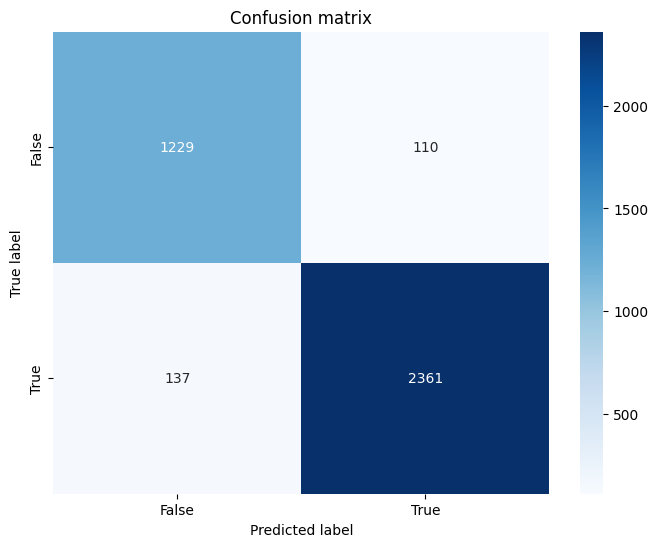

In [146]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.title("Confusion matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

Confusion matrix also shows less missclassification compared to the logistic regression based on engineered features.

In [147]:
roc_auc_val = roc_auc_score(y_val, y_val_prob)
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)

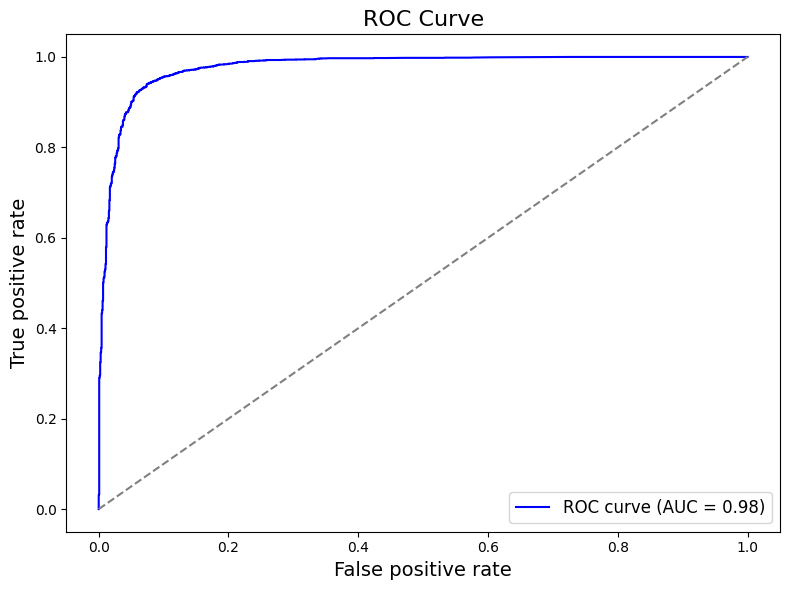

In [148]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_val:.2f})", color="blue")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.title("ROC Curve", fontsize=16)
plt.xlabel("False positive rate", fontsize=14)
plt.ylabel("True positive rate", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.show()

Slitghly better ROC-AUC (98>96) score shows better predictive performance as well.

In [149]:
feature_importances = best_rf_model.feature_importances_

In [150]:
importance_df = pd.DataFrame({
    'Feature': engineered_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

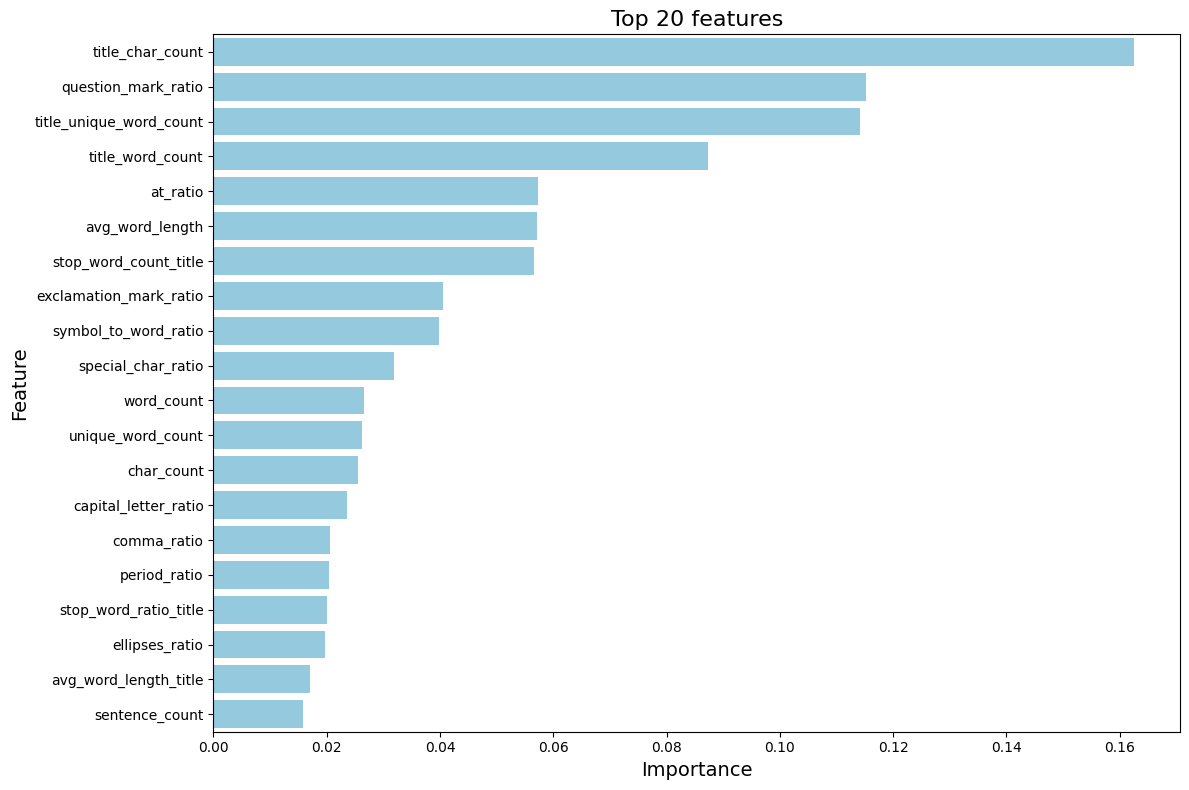

In [151]:
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', color="skyblue", orient='h')
plt.title("Top 20 features", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()

Features that are important in the random forest model are different than logstic regression we can see that most disitnguishing features include title char count, question mark ratio and title unique word count. Title features seem to be playing most important role in this model.

Lets have a look at one of the trees.

In [152]:
single_tree = best_rf_model.estimators_[0]

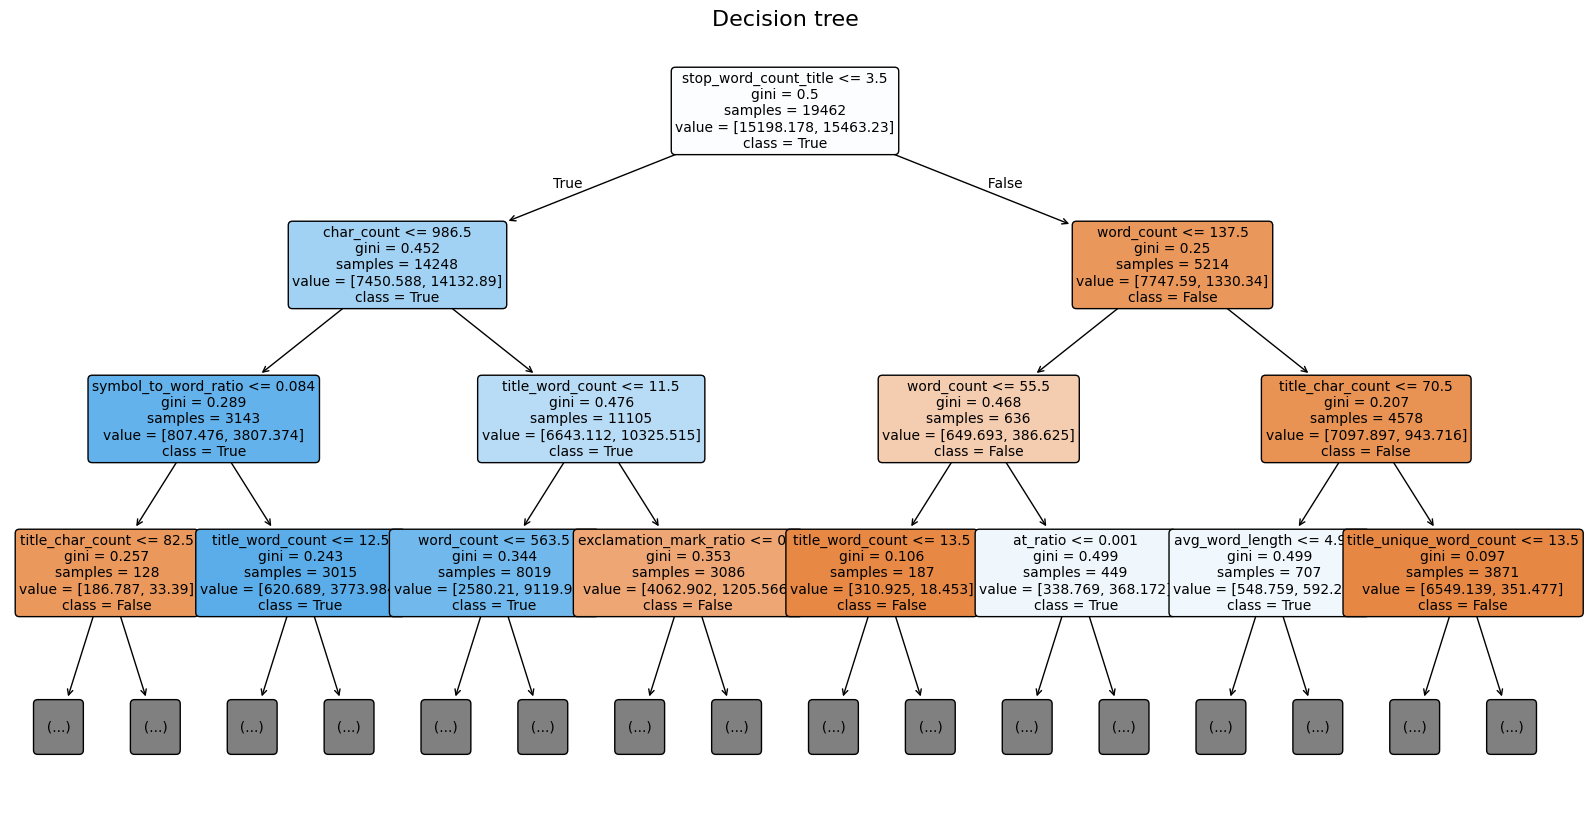

In [154]:
plt.figure(figsize=(20, 10))
plot_tree(
    single_tree,
    feature_names=engineered_features,
    class_names=["False", "True"],
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=10
)
plt.title("Decision tree", fontsize=16)
plt.show()

This decision tree begins splitting with the feature the number of stop words in title. This indicates that the model prioritizes this feature as a an important factor for distinguishing between the classes.

In [155]:
model_dir = "random_forest_model"
os.makedirs(model_dir, exist_ok=True)

In [156]:
model_path = os.path.join(model_dir, "random_forest_model.pkl")

In [157]:
joblib.dump(best_rf_model, model_path)

['random_forest_model/random_forest_model.pkl']

### Evaluating random forest on the test set

In [158]:
from random_forest_model import RandomForestEvaluationPipeline

In [159]:
pipeline = RandomForestEvaluationPipeline(model_dir="random_forest_model")

/content/drive/MyDrive/Fake news/preprocessing/text_processing_and_feature_engineering.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["text"] = dataset["text"].str.strip()
/content/drive/MyDrive/Fake news/preprocessing/text_processing_and_feature_engineering.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["title"] = dataset["title"].str.strip()
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was

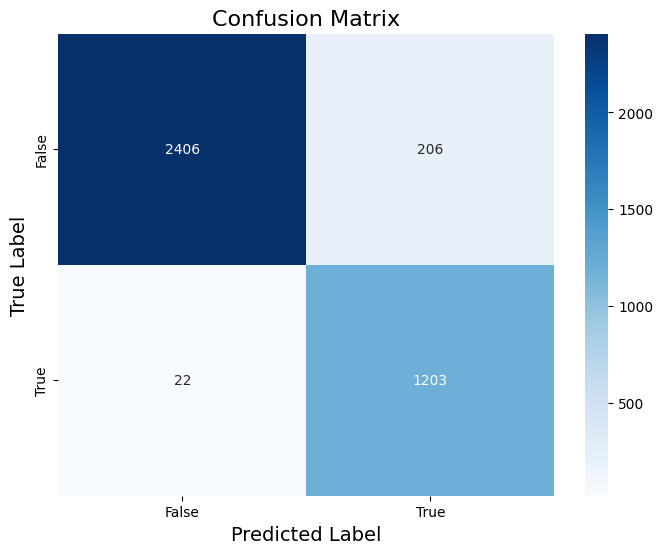

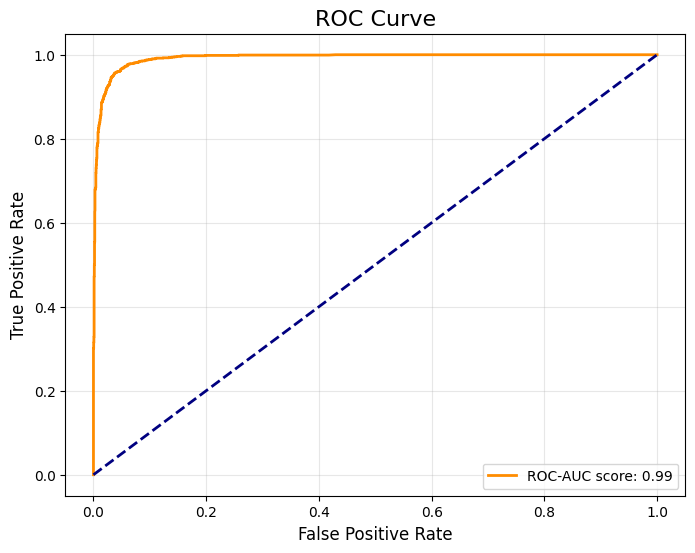

In [160]:
results = pipeline.evaluate(test_data, test_data["label"])

/content/drive/MyDrive/Fake news/preprocessing/text_processing_and_feature_engineering.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["text"] = dataset["text"].str.strip()
/content/drive/MyDrive/Fake news/preprocessing/text_processing_and_feature_engineering.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["title"] = dataset["title"].str.strip()
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was

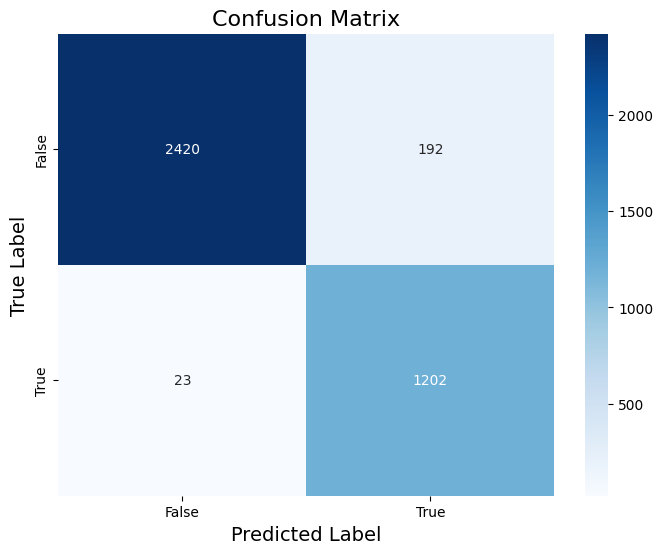

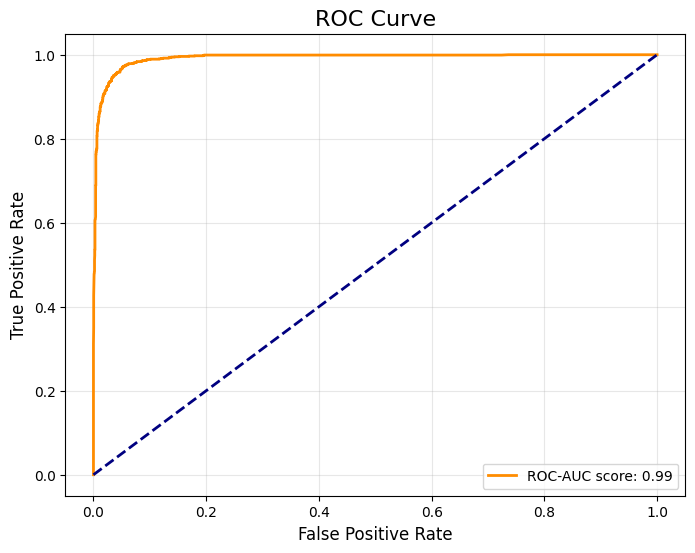

              precision    recall  f1-score   support

       False       0.99      0.93      0.96      2612
        True       0.86      0.98      0.92      1225

    accuracy                           0.94      3837
   macro avg       0.93      0.95      0.94      3837
weighted avg       0.95      0.94      0.94      3837

ROC-AUC: 0.9921305122355221


In [ ]:
print(results["classification_report"])
print("ROC-AUC:", results["roc_auc"])

Random forest results remain very good with test set as well despite it's different composition compared to validation set. Truthfull articles has a higher precision compared to the results of logistic regression model on the test set. Logistic regression model test set results for comparison:



```
  precision    recall  f1-score   support

       False       0.96      0.88      0.92      2612
        True       0.79      0.91      0.85      1225

    accuracy                           0.89      3837
   macro avg       0.87      0.90      0.88      3837
weighted avg       0.90      0.89      0.90      3837

```



### DistilBERT model for classification.

Finally we will evualte DistilBERT model capabilities with this binary task classification task. It is commonly used for binary classification and should be a good starting point in DL model direction. We will start from only feature extraction meaning no layers will be trained only the output. Later on we will introduce class weights and will try to see which parameters might work best for our classification with short optuna excersice. To save computations we will introduce title information only in the last steps.

As of starting point we will select some random hyperparameters to see if model even is suitable and how it performes with the data. We will start with batch size of 32, max length of tokens 100 and learning rate 0.0001.

In [15]:
train_df_masked["label"] = train_df_masked["label"].astype(int)
val_df_masked["label"] = val_df_masked["label"].astype(int)

In [19]:
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]["processed_text"]
        label = self.dataframe.iloc[idx]["label"]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

In [20]:
class TextDataModule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, tokenizer, max_length, batch_size):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = TextDataset(self.train_df, self.tokenizer, self.max_length)
        self.val_dataset = TextDataset(self.val_df, self.tokenizer, self.max_length)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

In [21]:
class DistilBERTClassifier(pl.LightningModule):
    def __init__(self, model_name, num_labels, learning_rate):
        super(DistilBERTClassifier, self).__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.learning_rate = learning_rate
        self.loss_fn = nn.CrossEntropyLoss()

        for param in self.model.distilbert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids=input_ids, attention_mask=attention_mask)

    def training_step(self, batch, batch_idx):
        outputs = self(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        logits = outputs.logits
        loss = self.loss_fn(logits, batch["label"])
        preds = torch.argmax(logits, dim=1)
        acc = (preds == batch["label"]).float().mean()

        self.log("train_loss", loss, on_step=False, on_epoch=True, batch_size=len(batch["label"]))
        self.log("train_acc", acc, on_step=False, on_epoch=True, batch_size=len(batch["label"]))
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        logits = outputs.logits
        val_loss = self.loss_fn(logits, batch["label"])
        preds = torch.argmax(logits, dim=1)
        acc = (preds == batch["label"]).float().mean()

        self.log("val_loss", val_loss, on_step=False, on_epoch=True, batch_size=len(batch["label"]))
        self.log("val_acc", acc, on_step=False, on_epoch=True, batch_size=len(batch["label"]))

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=self.learning_rate)

Since we are just want to see if DistilBERT is a good starting point we will start some randomly selected paramaters that we will try to tune in few next steps later.

In [22]:
MAX_LENGTH = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
NUM_LABELS = 2
MODEL_NAME = "distilbert-base-uncased"

In [23]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [24]:
train_data = train_df_masked[["processed_text", "label"]].copy()
val_data = val_df_masked[["processed_text", "label"]].copy()

In [25]:
data_module = TextDataModule(train_df=train_data, val_df=val_data, tokenizer=tokenizer, max_length=MAX_LENGTH, batch_size=BATCH_SIZE)

In [169]:
model_v1 = DistilBERTClassifier(model_name=MODEL_NAME, num_labels=NUM_LABELS, learning_rate=LEARNING_RATE)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [170]:
csv_logger = CSVLogger(save_dir="logs", name="distilbert_v1_logs")

In [26]:
early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min")

In [172]:
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    logger=csv_logger,
    callbacks=[early_stopping],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [27]:
torch.set_float32_matmul_precision('high')

In [174]:
trainer.fit(model_v1, datamodule=data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                                | Params | Mode 
------------------------------------------------------------------------
0 | model   | DistilBertForSequenceClassification | 67.0 M | eval 
1 | loss_fn | CrossEntropyLoss                    | 0      | train
------------------------------------------------------------------------
592 K     Trainable params
66.4 M    Non-trainable params
67.0 M    Total params
267.820   Total estimated model params size (MB)
1         Modules in train mode
96        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [178]:
def evaluate_on_validation(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(model.device)
            attention_mask = batch["attention_mask"].to(model.device)
            labels = batch["label"].to(model.device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)[:, 1]
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    print("Classification report:")
    print(classification_report(all_labels, all_preds, digits=4))

    conf_mat = confusion_matrix(all_labels, all_preds)
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    roc_auc = roc_auc_score(all_labels, all_probs)
    print(f"ROC-AUC: {roc_auc:.4f}")

    RocCurveDisplay.from_predictions(all_labels, all_probs)
    plt.title("ROC Curve")
    plt.show()

In [179]:
def plot_training_logs(log_csv_path):
    logs = pd.read_csv(log_csv_path)

    train_logs = logs[logs['train_loss'].notna()]
    val_logs = logs[logs['val_loss'].notna()]

    plt.figure(figsize=(10, 5))
    plt.plot(train_logs['epoch'], train_logs['train_acc'], label="Train accuracy")
    plt.plot(val_logs['epoch'], val_logs['val_acc'], label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_logs['epoch'], train_logs['train_loss'], label="Train loss")
    plt.plot(val_logs['epoch'], val_logs['val_loss'], label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

In [175]:
val_dataset = TextDataset(val_data, tokenizer, MAX_LENGTH)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Classification report:
              precision    recall  f1-score   support

           0     0.5598    0.9888    0.7149      1339
           1     0.9898    0.5833    0.7340      2498

    accuracy                         0.7248      3837
   macro avg     0.7748    0.7860    0.7245      3837
weighted avg     0.8398    0.7248    0.7273      3837



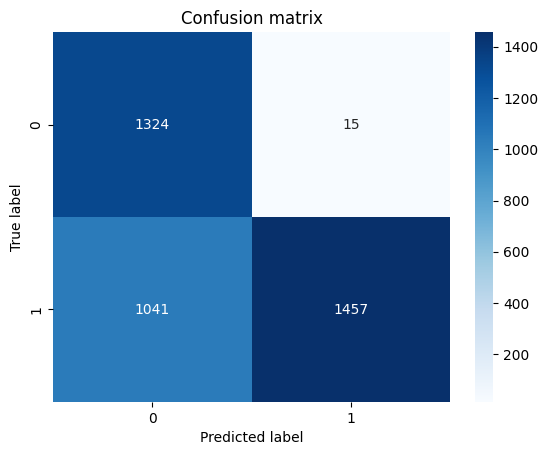

ROC-AUC: 0.9781


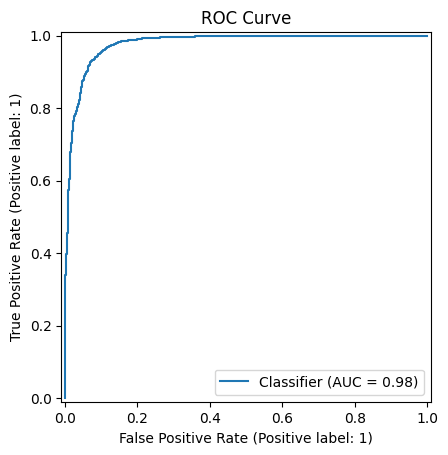

In [180]:
evaluate_on_validation(model_v1, val_loader)

The overall accuracy and f1 score of the model is 77% and 72%.

Confusion matrix highlights that the model struggles mostly with true text as it made 1041 misclassifications compared to 15 misclassification of false texts.

The ROC-AUC curve shows very good performance with score 0.98.

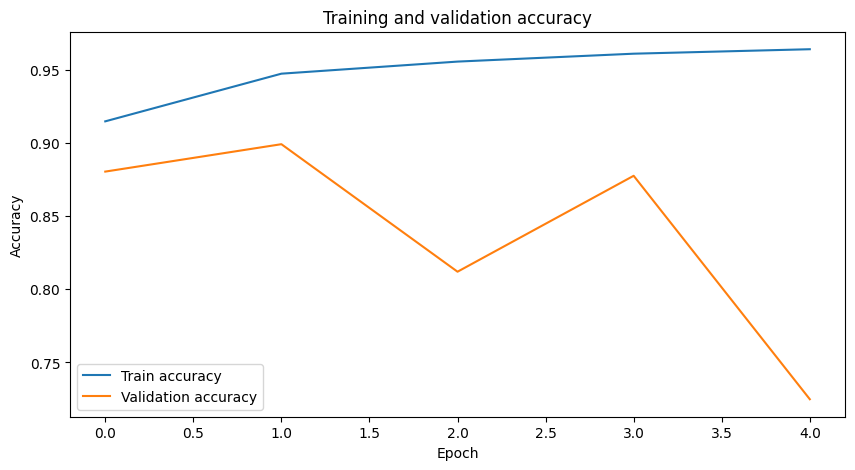

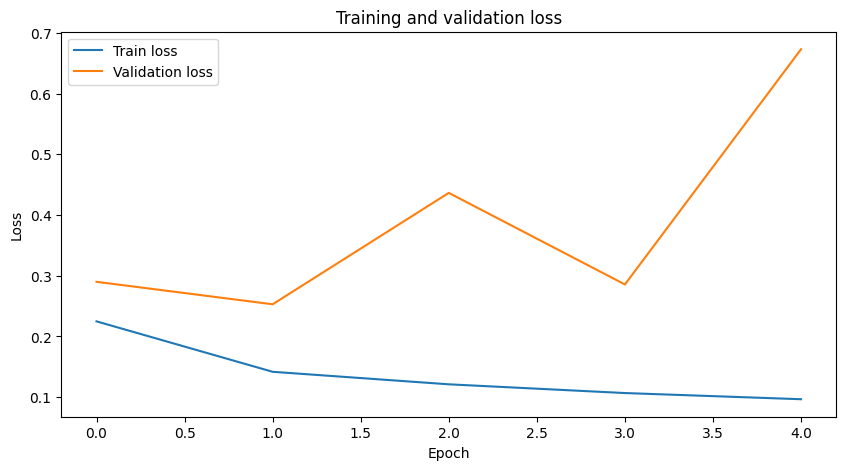

In [181]:
log_csv_path = "/content/drive/MyDrive/Fake news/logs/distilbert_v1_logs/version_0/metrics.csv"
plot_training_logs(log_csv_path)

Training accuracy continues to improve suggesting the model learns well from the training set while validations accuracy peaks at the 2nd epoch and stop improving indicating potential overfitting. Training loss steadily improves but validation loss stops improving after the 2nd epoch.

In order to improve our results we will run optuna for hyperparameters tuning with the same set up of only tuning the output layer. We will run 20 trials for only 3 epochs and will use later hyperparameters that yielded lowest validation loss during those epochs.

In [30]:
class DistilBERTClassifier(pl.LightningModule):
    def __init__(self, model_name, num_labels, learning_rate, dropout_rate, optimizer_name):
        super(DistilBERTClassifier, self).__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.optimizer_name = optimizer_name
        self.loss_fn = nn.CrossEntropyLoss()

        for param in self.model.distilbert.parameters():
            param.requires_grad = False

        self.dropout = nn.Dropout(self.dropout_rate)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.dropout(outputs.logits)
        return logits

    def training_step(self, batch, batch_idx):
        logits = self(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        loss = self.loss_fn(logits, batch["label"])
        preds = torch.argmax(logits, dim=1)
        acc = (preds == batch["label"]).float().mean()

        self.log("train_loss", loss, on_step=False, on_epoch=True, batch_size=len(batch["label"]))
        self.log("train_acc", acc, on_step=False, on_epoch=True, batch_size=len(batch["label"]))
        return loss

    def validation_step(self, batch, batch_idx):
        logits = self(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        val_loss = self.loss_fn(logits, batch["label"])
        preds = torch.argmax(logits, dim=1)
        acc = (preds == batch["label"]).float().mean()

        self.log("val_loss", val_loss, on_step=False, on_epoch=True, batch_size=len(batch["label"]))
        self.log("val_acc", acc, on_step=False, on_epoch=True, batch_size=len(batch["label"]))

    def configure_optimizers(self):
        if self.optimizer_name == "adamw":
            optimizer = AdamW(self.parameters(), lr=self.learning_rate, weight_decay=0.01)
        elif self.optimizer_name == "adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError("Unsupported optimizer. Choose either 'adam' or 'adamw'.")

        scheduler = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.5, verbose=True),
            "monitor": "val_loss",
            "interval": "epoch",
            "frequency": 1,
        }

        return [optimizer], [scheduler]

In [183]:
def create_dataloaders(train_data, val_data, tokenizer, max_length, batch_size):
    train_dataset = TextDataset(train_data, tokenizer, max_length)
    val_dataset = TextDataset(val_data, tokenizer, max_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [184]:
def objective(trial):
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    max_length = trial.suggest_categorical("max_length", [64, 128, 256])
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "adamw"])

    model_optuna = DistilBERTClassifier(
        model_name="distilbert-base-uncased",
        num_labels=2,
        learning_rate=learning_rate,
        dropout_rate=dropout_rate,
        optimizer_name=optimizer_name
    )

    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    train_loader, val_loader = create_dataloaders(
        train_data, val_data, tokenizer, max_length=max_length, batch_size=batch_size
    )

    csv_logger = CSVLogger(save_dir="logs", name=f"distilbert_optunas_trials_{trial.number}")

    trainer = pl.Trainer(
        max_epochs=3,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        logger=csv_logger,
        enable_progress_bar=True
    )

    trainer.fit(model_optuna, train_loader, val_loader)

    best_val_loss = trainer.callback_metrics["val_loss"].item()
    return best_val_loss

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

In [187]:
print("Best trial:")
print(f"Value: {study.best_trial.value}")
print("Parameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial:
Value: 0.14879582822322845
Parameters:
    learning_rate: 0.00024057037576553087
    batch_size: 32
    max_length: 256
    dropout_rate: 0.4133398176884159
    optimizer: adam


In [188]:
def plot_optuna_study_results(study):
    trials_df = study.trials_dataframe()

    plt.figure(figsize=(10, 5))
    plt.plot(trials_df['number'], trials_df['value'], marker='o', label='Validation loss')
    plt.xlabel('Trial number')
    plt.ylabel('Validation Loss')
    plt.title('Optuna trials validation loss')
    plt.legend()
    plt.grid()
    plt.show()

    hyperparameter_columns = ['params_learning_rate', 'params_batch_size',
                              'params_max_length', 'params_dropout_rate', 'params_optimizer']
    if all(col in trials_df.columns for col in hyperparameter_columns):
        trials_df[hyperparameter_columns + ['value']].rename(columns={
            'params_learning_rate': 'Learning Rate',
            'params_batch_size': 'Batch Size',
            'params_max_length': 'Max Length',
            'params_dropout_rate': 'Dropout Rate',
            'params_optimizer': 'Optimizer',
            'value': 'Validation Loss'
        }).boxplot(column='Validation Loss', by='Optimizer', grid=False, figsize=(10, 5))
        plt.title('Validation Loss by Optimizer')
        plt.suptitle("")
        plt.ylabel('Validation Loss')
        plt.show()

    for param in ['params_learning_rate', 'params_batch_size', 'params_max_length', 'params_dropout_rate']:
        if param in trials_df.columns:
            plt.figure(figsize=(10, 5))
            plt.scatter(trials_df[param], trials_df['value'], alpha=0.7)
            plt.xlabel(param.replace('params_', '').replace('_', ' ').capitalize())
            plt.ylabel('Validation loss')
            plt.title(f'{param.replace("params_", "").replace("_", " ").capitalize()} vs Validation Loss')
            plt.grid()
            plt.show()

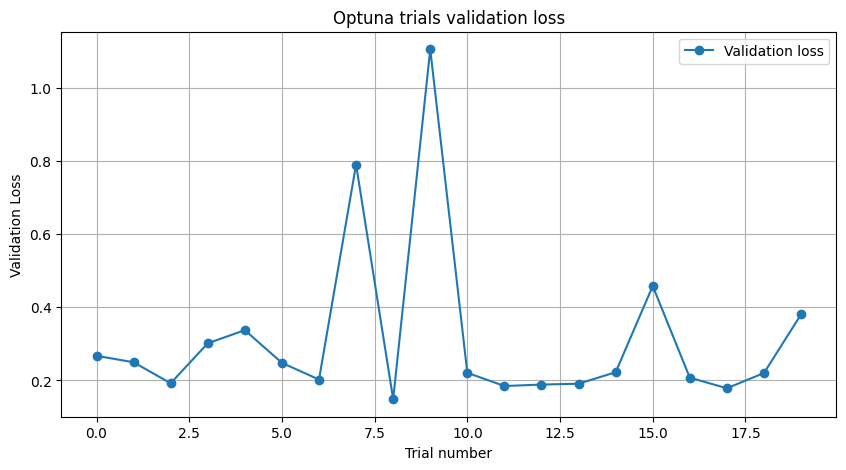

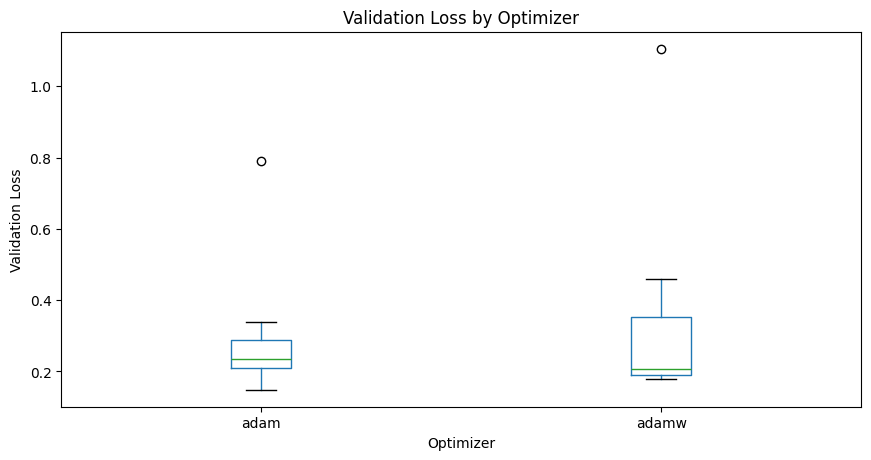

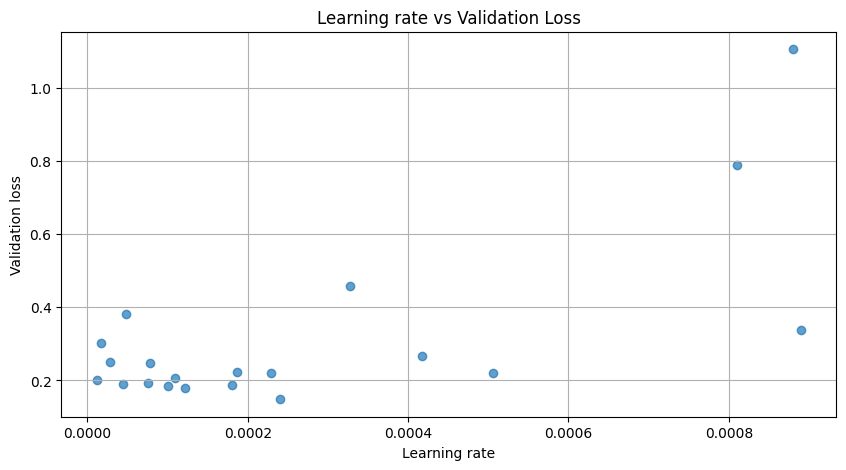

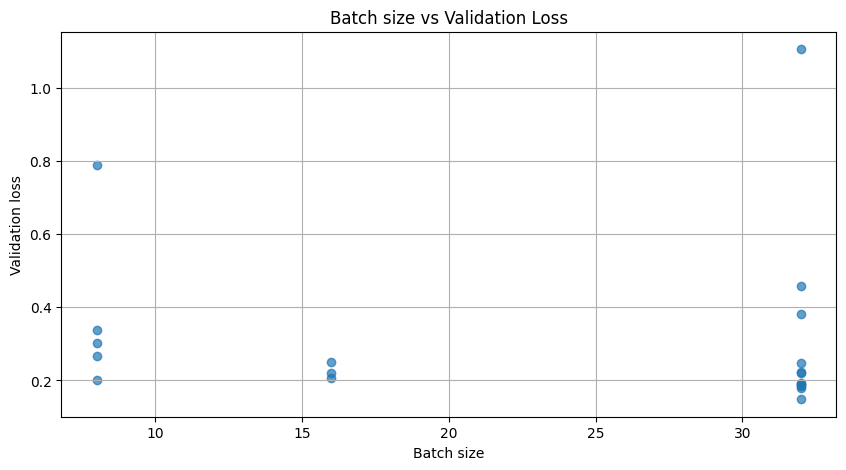

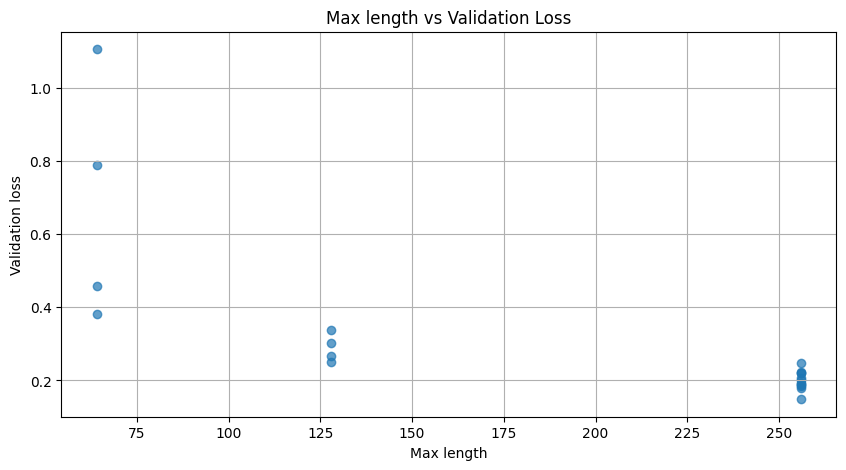

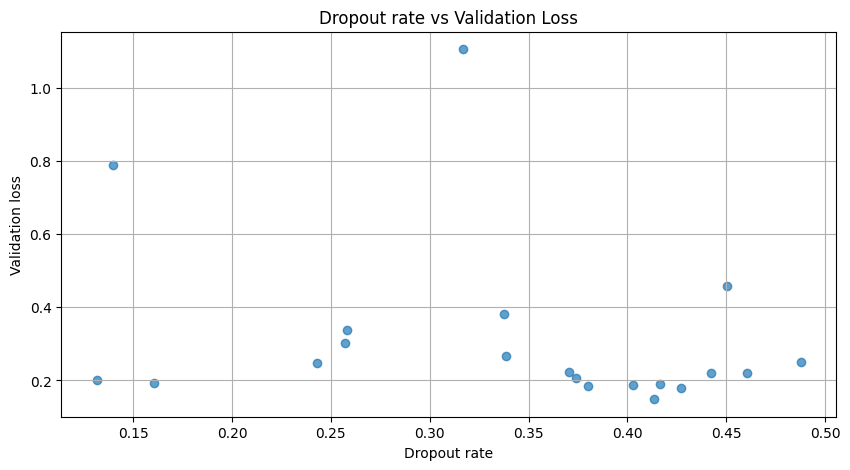

In [189]:
plot_optuna_study_results(study)

From trial results above we can see that combination of adam as optimizer, lower learning rates and higher max lengths results in the better performance during first epochs.

Training on best hyperparameters set found during 20 trials.

Best trial:
Value: 0.14879582822322845
Parameters:
    learning_rate: 0.00024057037576553087
    batch_size: 32
    max_length: 256
    dropout_rate: 0.4133398176884159
    optimizer: adam

In [22]:
MAX_LENGTH = 256
BATCH_SIZE = 32
LEARNING_RATE = 0.00024057037576553087
NUM_LABELS = 2
DROPOUT_RATE = 0.4133398176884159
OPTIMIZER_NAME = "adam"
MODEL_NAME = "distilbert-base-uncased"

In [31]:
model_v2 = DistilBERTClassifier(model_name=MODEL_NAME, num_labels=NUM_LABELS, learning_rate=LEARNING_RATE,dropout_rate = DROPOUT_RATE, optimizer_name = OPTIMIZER_NAME)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
csv_logger = CSVLogger(save_dir="logs", name="distilbert_v2_logs")

In [33]:
trainer = pl.Trainer(
    max_epochs=20,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    logger=csv_logger,
    callbacks=[early_stopping],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [34]:
trainer.fit(model_v2, datamodule=data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                                | Params | Mode 
------------------------------------------------------------------------
0 | model   | DistilBertForSequenceClassification | 67.0 M | eval 
1 | loss_fn | CrossEntropyLoss                    | 0      | train
2 | dropout | Dropout                             | 0      | train
------------------------------------------------------------------------
592 K     Trainable params
66.4 M    Non-trainable params
67.0 M    Total params
267.820   Total estimated model params size (MB)
2         Modules in train mode
96        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [35]:
def evaluate_on_validation(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(model.device)
            attention_mask = batch["attention_mask"].to(model.device)
            labels = batch["label"].to(model.device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)

            probs = torch.softmax(logits, dim=1)[:, 1]
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    print("Classification report:")
    print(classification_report(all_labels, all_preds, digits=4))

    conf_mat = confusion_matrix(all_labels, all_preds)
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    roc_auc = roc_auc_score(all_labels, all_probs)
    print(f"ROC-AUC: {roc_auc:.4f}")

    RocCurveDisplay.from_predictions(all_labels, all_probs)
    plt.title("ROC curve")
    plt.show()

In [36]:
def plot_training_logs(log_csv_path):
    logs = pd.read_csv(log_csv_path)

    train_logs = logs[logs['train_loss'].notna()]
    val_logs = logs[logs['val_loss'].notna()]

    plt.figure(figsize=(10, 5))
    plt.plot(train_logs['epoch'], train_logs['train_acc'], label="Train accuracy")
    plt.plot(val_logs['epoch'], val_logs['val_acc'], label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_logs['epoch'], train_logs['train_loss'], label="Train loss")
    plt.plot(val_logs['epoch'], val_logs['val_loss'], label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

In [37]:
val_dataset = TextDataset(val_data, tokenizer, MAX_LENGTH)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Classification report:
              precision    recall  f1-score   support

           0     0.7286    0.9783    0.8352      1339
           1     0.9858    0.8046    0.8860      2498

    accuracy                         0.8653      3837
   macro avg     0.8572    0.8915    0.8606      3837
weighted avg     0.8960    0.8653    0.8683      3837



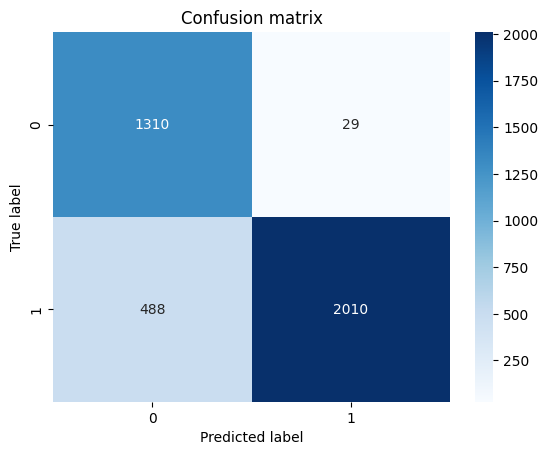

ROC-AUC: 0.9832


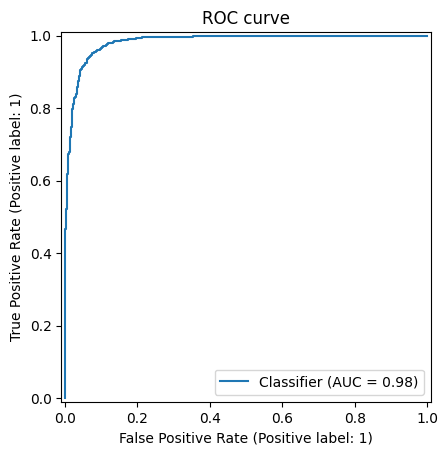

In [38]:
evaluate_on_validation(model_v2, val_loader)

With tuned hyperparameters averall accuracy and f1 score improved to 86% and there is a lot less false text misclasification. There are 29 false positives and 488 false negatives which is indicating slightly higher misclassification in identifying the true articles. To address this we will include inversly proportional weights to the loss function.

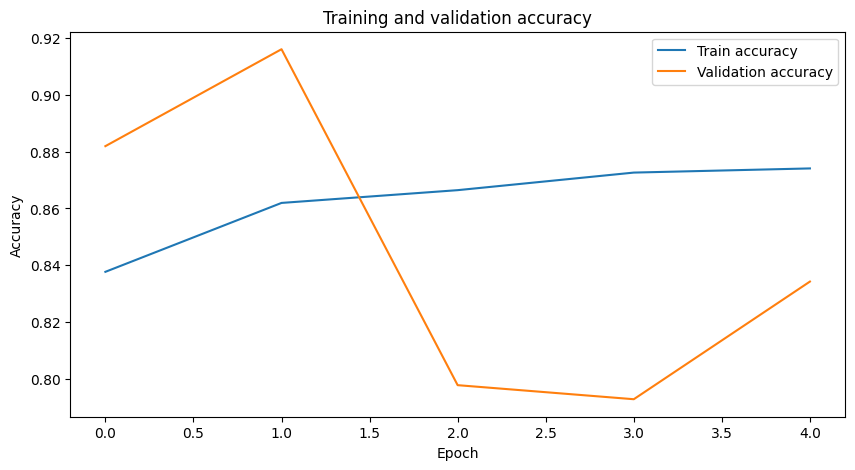

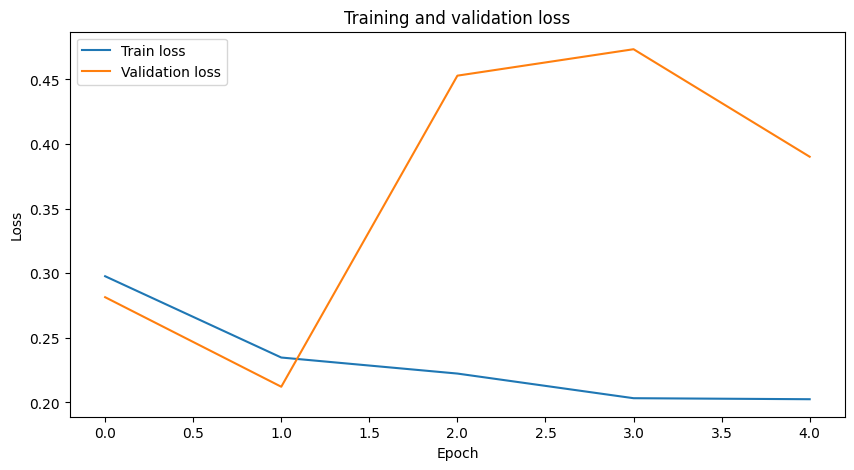

In [39]:
log_csv_path = "/content/drive/MyDrive/Fake news/logs/distilbert_v2_logs/version_0/metrics.csv"
plot_training_logs(log_csv_path)

Even though our attempt to get more suitable hyperparameters set got better performance results we can see that training and validation logs displays the same pattern of improving until only the second epoch. Model still shows signs of overfitting.

#### Integrating class weights

In [24]:
classes = train_data["label"].unique()
class_weights = compute_class_weight("balanced", classes=classes, y=train_data["label"].values)
class_weights = dict(zip(classes, class_weights))
print("Class weights:", class_weights)

Class weights: {True: 0.8786924662239524, False: 1.1601662887377173}


In [41]:
class DistilBERTClassifierWeighted(pl.LightningModule):
    def __init__(self, model_name, num_labels, learning_rate, dropout_rate, optimizer_name, class_weights=None):
        super(DistilBERTClassifierWeighted, self).__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.optimizer_name = optimizer_name

        if class_weights is not None:
            self.loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32))
        else:
            self.loss_fn = nn.CrossEntropyLoss()

        for param in self.model.distilbert.parameters():
            param.requires_grad = False

        self.dropout = nn.Dropout(self.dropout_rate)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.dropout(outputs.logits)
        return logits

    def training_step(self, batch, batch_idx):
        logits = self(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        loss = self.loss_fn(logits, batch["label"])
        preds = torch.argmax(logits, dim=1)
        acc = (preds == batch["label"]).float().mean()

        self.log("train_loss", loss, on_step=False, on_epoch=True, batch_size=len(batch["label"]))
        self.log("train_acc", acc, on_step=False, on_epoch=True, batch_size=len(batch["label"]))
        return loss

    def validation_step(self, batch, batch_idx):
        logits = self(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        val_loss = self.loss_fn(logits, batch["label"])
        preds = torch.argmax(logits, dim=1)
        acc = (preds == batch["label"]).float().mean()

        self.log("val_loss", val_loss, on_step=False, on_epoch=True, batch_size=len(batch["label"]))
        self.log("val_acc", acc, on_step=False, on_epoch=True, batch_size=len(batch["label"]))

    def configure_optimizers(self):
        if self.optimizer_name == "adamw":
            optimizer = AdamW(self.parameters(), lr=self.learning_rate, weight_decay=0.01)
        elif self.optimizer_name == "adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError("Unsupported optimizer. Choose either 'adam' or 'adamw'.")

        scheduler = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.5, verbose=True),
            "monitor": "val_loss",
            "interval": "epoch",
            "frequency": 1,
        }

        return [optimizer], [scheduler]

In [42]:
model_v3 = DistilBERTClassifierWeighted(
    model_name=MODEL_NAME,
    num_labels=NUM_LABELS,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    optimizer_name=OPTIMIZER_NAME,
    class_weights=[class_weights[i] for i in range(NUM_LABELS)]
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
csv_logger = CSVLogger(save_dir="logs", name="distilbert_v3_logs")

In [44]:
trainer = pl.Trainer(
    max_epochs=20,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    logger=csv_logger,
    callbacks=[early_stopping],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [45]:
trainer.fit(model_v3, datamodule=data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                                | Params | Mode 
------------------------------------------------------------------------
0 | model   | DistilBertForSequenceClassification | 67.0 M | eval 
1 | loss_fn | CrossEntropyLoss                    | 0      | train
2 | dropout | Dropout                             | 0      | train
------------------------------------------------------------------------
592 K     Trainable params
66.4 M    Non-trainable params
67.0 M    Total params
267.820   Total estimated model params size (MB)
2         Modules in train mode
96        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Classification report:
              precision    recall  f1-score   support

           0     0.6701    0.9768    0.7949      1339
           1     0.9836    0.7422    0.8460      2498

    accuracy                         0.8241      3837
   macro avg     0.8268    0.8595    0.8204      3837
weighted avg     0.8742    0.8241    0.8282      3837



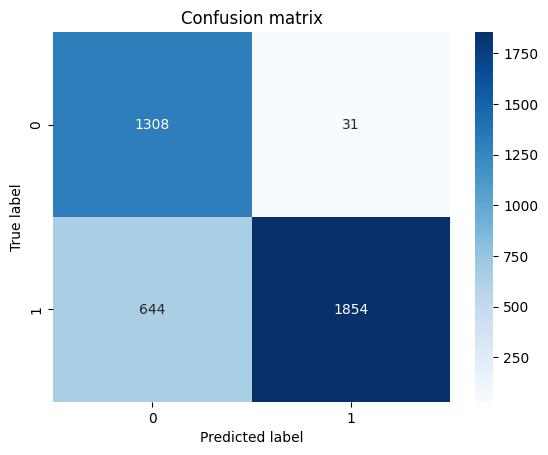

ROC-AUC: 0.9778


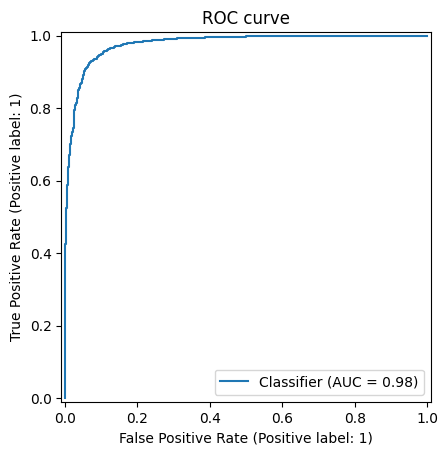

In [47]:
evaluate_on_validation(model_v3, val_loader)

We can see that overall results with class weights are a bit worse than without.

In [59]:
#log_csv_path = "/content/drive/MyDrive/Fake news/logs/distilbert_v3_logs/version_0/metrics.csv"
#plot_training_logs(log_csv_path)

We will compare all 3 models using different approaches. To ensure consistency across the models we will include titles text in the dataset ensuring that all models are trained and evaluated using the same data.

In [35]:
class CombinedTextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]["processed_text"]
        title = self.dataframe.iloc[idx]["processed_title"]
        label = self.dataframe.iloc[idx]["label"]

        combined_text = f"{title} [SEP] {text}"
        encoding = self.tokenizer(
            combined_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

In [36]:
class CombinedTextDataModule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, tokenizer, max_length, batch_size):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = CombinedTextDataset(self.train_df, self.tokenizer, self.max_length)
        self.val_dataset = CombinedTextDataset(self.val_df, self.tokenizer, self.max_length)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

In [18]:
class CombinedDistilBERTClassifier(pl.LightningModule):
    def __init__(self, model_name, num_labels, learning_rate, dropout_rate, optimizer_name):
        super(CombinedDistilBERTClassifier, self).__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.optimizer_name = optimizer_name
        self.loss_fn = nn.CrossEntropyLoss()

        for param in self.model.distilbert.parameters():
            param.requires_grad = False

        self.dropout = nn.Dropout(self.dropout_rate)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.dropout(outputs.logits)
        return logits

    def training_step(self, batch, batch_idx):
        logits = self(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        loss = self.loss_fn(logits, batch["label"])
        preds = torch.argmax(logits, dim=1)
        acc = (preds == batch["label"]).float().mean()

        self.log("train_loss", loss, on_step=False, on_epoch=True, batch_size=len(batch["label"]))
        self.log("train_acc", acc, on_step=False, on_epoch=True, batch_size=len(batch["label"]))
        return loss

    def validation_step(self, batch, batch_idx):
        logits = self(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        val_loss = self.loss_fn(logits, batch["label"])
        preds = torch.argmax(logits, dim=1)
        acc = (preds == batch["label"]).float().mean()

        self.log("val_loss", val_loss, on_step=False, on_epoch=True, batch_size=len(batch["label"]))
        self.log("val_acc", acc, on_step=False, on_epoch=True, batch_size=len(batch["label"]))

    def configure_optimizers(self):
        if self.optimizer_name == "adamw":
            optimizer = AdamW(self.parameters(), lr=self.learning_rate, weight_decay=0.01)
        elif self.optimizer_name == "adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError("Unsupported optimizer. Choose either 'adam' or 'adamw'.")

        scheduler = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.5, verbose=True),
            "monitor": "val_loss",
            "interval": "epoch",
            "frequency": 1,
        }

        return [optimizer], [scheduler]

In [37]:
train_data = train_df_masked[["processed_text", "processed_title", "label"]].copy()
val_data = val_df_masked[["processed_text", "processed_title", "label"]].copy()

In [38]:
data_module = CombinedTextDataModule(train_df=train_data, val_df=val_data, tokenizer=tokenizer, max_length=MAX_LENGTH, batch_size=BATCH_SIZE)

In [54]:
model_v4 = CombinedDistilBERTClassifier(
    model_name=MODEL_NAME,
    num_labels=NUM_LABELS,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    optimizer_name=OPTIMIZER_NAME,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
csv_logger = CSVLogger(save_dir="logs", name="distilbert_combined_logs")

In [56]:
early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min")

In [57]:
trainer = pl.Trainer(
    max_epochs=20,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    logger=csv_logger,
    callbacks=[early_stopping],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [58]:
trainer.fit(model_v4, datamodule=data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                                | Params | Mode 
------------------------------------------------------------------------
0 | model   | DistilBertForSequenceClassification | 67.0 M | eval 
1 | loss_fn | CrossEntropyLoss                    | 0      | train
2 | dropout | Dropout                             | 0      | train
------------------------------------------------------------------------
592 K     Trainable params
66.4 M    Non-trainable params
67.0 M    Total params
267.820   Total estimated model params size (MB)
2         Modules in train mode
96        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [60]:
val_loader = data_module.val_dataloader()

Classification report:
              precision    recall  f1-score   support

           0     0.8809    0.9664    0.9217      1339
           1     0.9810    0.9299    0.9548      2498

    accuracy                         0.9427      3837
   macro avg     0.9309    0.9482    0.9382      3837
weighted avg     0.9461    0.9427    0.9432      3837



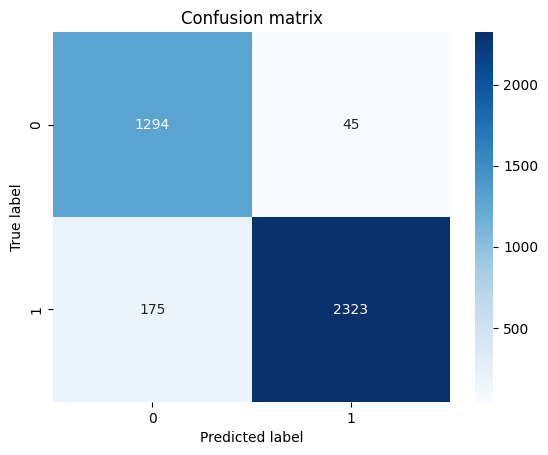

ROC-AUC: 0.9920


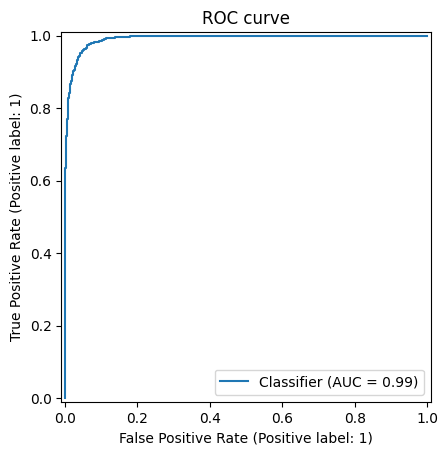

In [61]:
evaluate_on_validation(model_v4, val_loader)

With added title we have improved our results quite a lot to 93% accuracy and 94% f1 score. Classification report of the last model of only articles text:


```
Classification report:
              precision    recall  f1-score   support

           0     0.6701    0.9768    0.7949      1339
           1     0.9836    0.7422    0.8460      2498

    accuracy                         0.8241      3837
   macro avg     0.8268    0.8595    0.8204      3837
weighted avg     0.8742    0.8241    0.8282      3837
```

We have around 220 misclassification with more misclassifications of true articles 175 > 45.


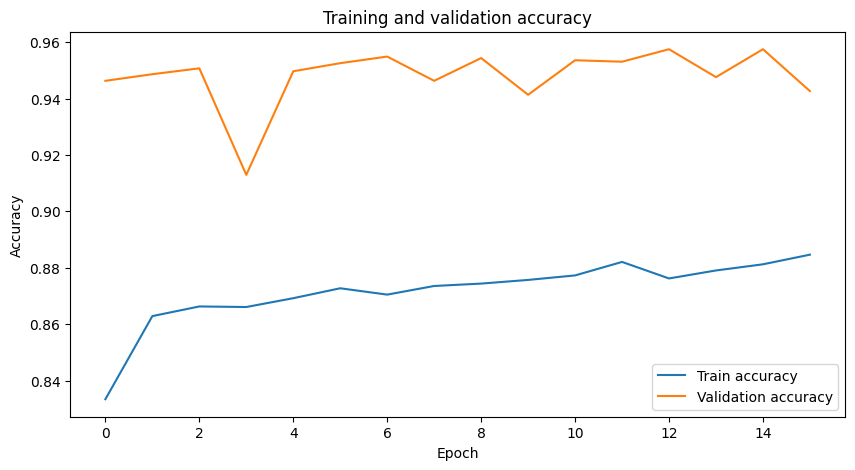

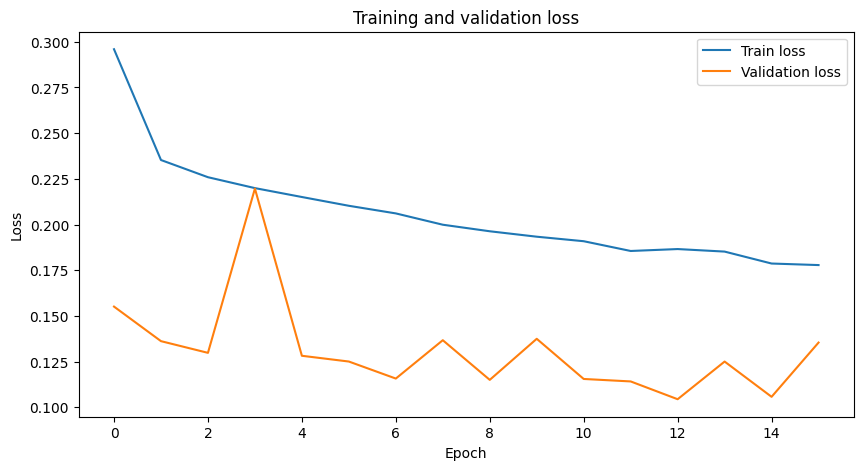

In [62]:
log_csv_path = "/content/drive/MyDrive/Fake news/logs/distilbert_combined_logs/version_0/metrics.csv"
plot_training_logs(log_csv_path)

Included title did change model performance and with it we can see some stabilization in the model, but regularization might be too strong from visible gap between training and validation performance, former one showing a lot better results. We should consider lower drop out rate and/or learning rate and see what kind of effect it could have on the training performance.

We will test this model with test set as well and see how DistilBERT compares to the logistic regression and random forest attempts at classification.

### Evaluating DistilBERT model on the test set

In [63]:
model_dir = "distilbert_combined_model"
os.makedirs(model_dir, exist_ok=True)

In [64]:
model_path = os.path.join(model_dir, "distilbert_combined_model.pt")
torch.save(model_v4.state_dict(), model_path)

In [25]:
class CombinedDistilBERTEvaluationPipeline:
    def __init__(self, model_dir, model_class, model_name, num_labels, tokenizer, max_length):
        self.model_path = os.path.join(model_dir, "distilbert_combined_model.pt")
        self.model = model_class(
            model_name=model_name,
            num_labels=num_labels,
            learning_rate=5.636655332464454e-05,
            dropout_rate=0.19122686541752332,
            optimizer_name="adam",
        )
        self.model.load_state_dict(torch.load(self.model_path))
        self.model.eval()
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.nlp = spacy.load("en_core_web_sm")

    def preprocess(self, dataframe):
        processed_data = []
        for idx in range(len(dataframe)):
            text = dataframe.iloc[idx]["text"]
            title = dataframe.iloc[idx]["title"]

            processed_text = preprocess_text(normalize_text(text))
            processed_title = preprocess_text(normalize_text(title))

            combined_text = f"{processed_title} [SEP] {processed_text}"
            encoding = self.tokenizer(
                combined_text,
                max_length=self.max_length,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            )
            processed_data.append({
                "input_ids": encoding["input_ids"].squeeze(0),
                "attention_mask": encoding["attention_mask"].squeeze(0),
                "label": torch.tensor(dataframe.iloc[idx]["label"], dtype=torch.long),
            })
        return processed_data

    def predict(self, dataframe):
        processed_data = self.preprocess(dataframe)
        predictions, probabilities, true_labels = [], [], []

        for data in processed_data:
            input_ids = data["input_ids"].unsqueeze(0)
            attention_mask = data["attention_mask"].unsqueeze(0)
            label = data["label"]

            with torch.no_grad():
                logits = self.model(input_ids=input_ids, attention_mask=attention_mask)
                probs = torch.softmax(logits, dim=1)
                pred = torch.argmax(probs, dim=1)

            predictions.append(pred.item())
            probabilities.append(probs[:, 1].item())
            true_labels.append(label.item())

        return {
            "predictions": predictions,
            "probabilities": probabilities,
            "true_labels": true_labels,
        }

    def evaluate(self, dataframe):
        results = self.predict(dataframe)
        predictions = results["predictions"]
        probabilities = results["probabilities"]
        true_labels = results["true_labels"]

        report = classification_report(true_labels, predictions)
        conf_matrix = confusion_matrix(true_labels, predictions)
        roc_auc = roc_auc_score(true_labels, probabilities)

        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["False", "True"], yticklabels=["False", "True"])
        plt.title("Confusion Matrix", fontsize=16)
        plt.xlabel("Predicted Label", fontsize=14)
        plt.ylabel("True Label", fontsize=14)
        plt.show()

        fpr, tpr, _ = roc_curve(true_labels, probabilities)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"ROC-AUC score: {roc_auc:.2f}", color="darkorange", lw=2)
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlabel("False Positive Rate", fontsize=12)
        plt.ylabel("True Positive Rate", fontsize=12)
        plt.title("ROC Curve", fontsize=16)
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        plt.show()

        return {
            "classification_report": report,
            "confusion_matrix": conf_matrix,
            "roc_auc": roc_auc,
        }

In [26]:
evaluation_pipeline = CombinedDistilBERTEvaluationPipeline(
    model_dir="distilbert_combined_model",
    model_class=CombinedDistilBERTClassifier,
    model_name="distilbert-base-uncased",
    num_labels=2,
    tokenizer=tokenizer,
    max_length=256,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-25-2f5199dec8a9>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by

<ipython-input-25-2f5199dec8a9>:38: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  "label": torch.tensor(dataframe.iloc[idx]["label"], dtype=torch.long),


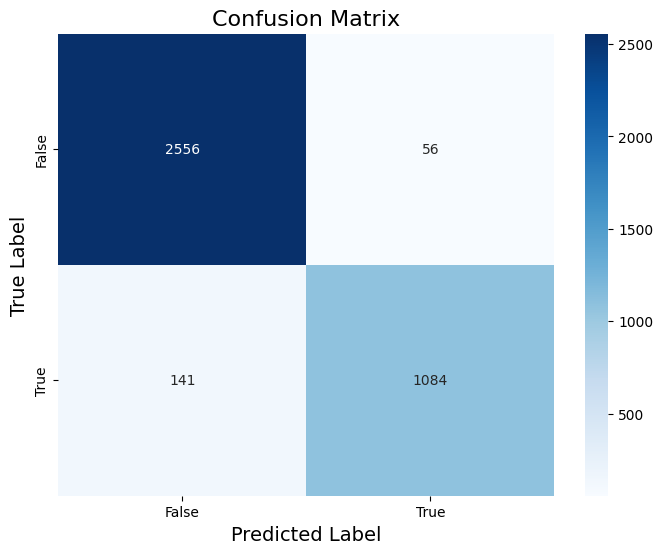

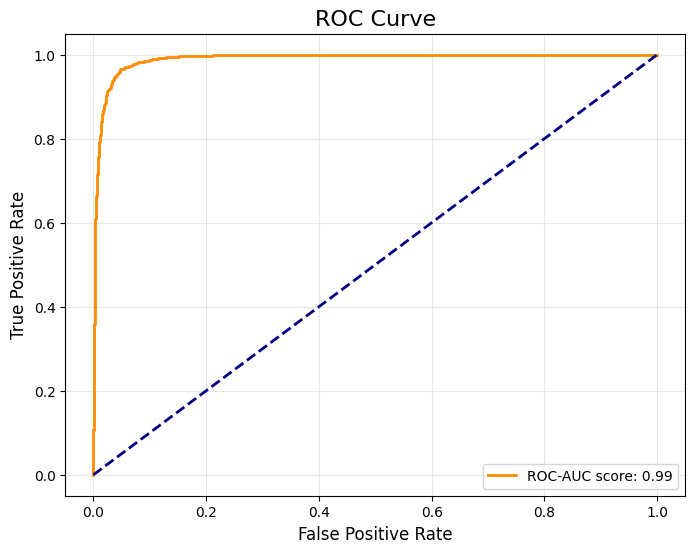

In [30]:
DistilB_results = evaluation_pipeline.evaluate(test_data)

In [31]:
print(DistilB_results["classification_report"])
print("ROC-AUC:", DistilB_results["roc_auc"])

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      2612
           1       0.95      0.88      0.92      1225

    accuracy                           0.95      3837
   macro avg       0.95      0.93      0.94      3837
weighted avg       0.95      0.95      0.95      3837

ROC-AUC: 0.9902934650123448


DistlBERT model even with a lot place to improve shows the best results so far.

#### Mistakes analysis

In [32]:
checkpoint_path = "/content/drive/MyDrive/Fake news/logs/distilbert_combined_logs/version_0/checkpoints/epoch=15-step=15360.ckpt"

In [33]:
model_v4 = CombinedDistilBERTClassifier.load_from_checkpoint(
    checkpoint_path,
    model_name=MODEL_NAME,
    num_labels=NUM_LABELS,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    optimizer_name=OPTIMIZER_NAME
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
data_module.setup()

In [40]:
val_loader = data_module.val_dataloader()

In [41]:
def get_misclassified_samples(model, val_loader, val_df):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    indices = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            input_ids = batch["input_ids"].to(model.device)
            attention_mask = batch["attention_mask"].to(model.device)
            labels = batch["label"].to(model.device)

            logits = model(input_ids=input_ids,
                           attention_mask=attention_mask)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            indices.extend(batch.get("index", list(range(len(batch["label"])))) if "index" in batch else range(len(labels)))

    results = pd.DataFrame({
        "index": indices,
        "predicted_label": all_preds,
        "true_label": all_labels,
        "confidence": [p.max() for p in all_probs]
    })

    results = results.merge(val_df.reset_index(), left_on="index", right_index=True)
    mistakes = results[results["predicted_label"] != results["true_label"]]

    print(f"Total misclassified: {len(mistakes)}")
    return mistakes

In [42]:
val_mistakes = get_misclassified_samples(model_v4, val_loader, val_data)

Total misclassified: 220


In [43]:
val_mistakes.to_csv("misclassified_samples.csv", index=False)

In [44]:
for _, row in val_mistakes.head(5).iterrows():
    print(f"Processed text: {row['processed_text']}")
    print(f"Processed title: {row['processed_title']}")
    print(f"True label: {row['true_label']}")
    print(f"Predicted label: {row['predicted_label']}")
    print("----")

Processed text: washington reuters president donald trump will visit a border protection facility in a town along the u s mexican border in arizona on tuesday as he seek congressional funding for the wall he want build administration official say on monday trump who have struggle to persuade the republican lead congress to approve funding for a project many see as unnecessary be to visit the facility in yuma arizona the border area at yuma be consider a success story for the u s border patrol because illegal crossing have slow as a result of the border installation trump will not go to the border wall at yuma as official have say early in the day instead he will tour a u s custom and border patrol hangar and see some of the equipment use to monitor the border include a predator drone a patrol boat and a surveillance truck the official say during his visit trump will be brief on border patrol effort in the region and the need for more funding for immigration and border official to carry

It's hard to say what excatly causes misclassifications in these cases. We are going to use LIME analysis to examine which parts of the text or title contribute most to the predictions.

In [45]:
def lime_analysis(row, model, tokenizer, max_length, num_features=10, num_samples=1000):
    combined_text = f"{row['processed_title']} [SEP] {row['processed_text']}"

    device = next(model.parameters()).device

    def predict_proba(texts):
        tokenized = tokenizer(
            texts,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids = tokenized["input_ids"].to(device)
        attention_mask = tokenized["attention_mask"].to(device)

        with torch.no_grad():
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
        return probs

    explainer = LimeTextExplainer(class_names=["Class 0", "Class 1"])

    exp = explainer.explain_instance(
        combined_text, predict_proba, num_features=num_features, num_samples=num_samples
    )

    print(f"Processed title: {row['processed_title']}")
    print(f"Processed text: {row['processed_text']}")
    print(f"True label: {row['true_label']}")
    print(f"Predicted label: {row['predicted_label']}")
    print(f"Confidence: {row['confidence']:.2f}")
    exp.show_in_notebook(text=True)
    print("----")

In [46]:
for _, row in val_mistakes.head(3).iterrows():
    torch.cuda.empty_cache()
    lime_analysis(row, model_v4, tokenizer, max_length=MAX_LENGTH, num_features=10, num_samples=500)

Processed title: trump to visit arizona town on u s mexican border
Processed text: washington reuters president donald trump will visit a border protection facility in a town along the u s mexican border in arizona on tuesday as he seek congressional funding for the wall he want build administration official say on monday trump who have struggle to persuade the republican lead congress to approve funding for a project many see as unnecessary be to visit the facility in yuma arizona the border area at yuma be consider a success story for the u s border patrol because illegal crossing have slow as a result of the border installation trump will not go to the border wall at yuma as official have say early in the day instead he will tour a u s custom and border patrol hangar and see some of the equipment use to monitor the border include a predator drone a patrol boat and a surveillance truck the official say during his visit trump will be brief on border patrol effort in the region and the

----
Processed title: factbox trump evolving view of the afghan conflict
Processed text: reuters president donald trump be likely to open the door on monday to a modest increase in u s troop number in afghanistan where america be fight its long military conflict in the past trump who take office in january be critical of former democratic president barack obama s approach to afghanistan say the united states should not be nation building and call for obama to withdraw troop obama also have evolve view first commit an increase of ten of thousand of u s troop to reverse taliban gain then commit to a troop drawdown that he be unable to complete before leave office follow be some of trump s comment on the war before and after he launch his white house run in june oct when will we stop waste our money on rebuild afghanistan we must rebuild our country first post on twitter during a year when obama s troop surge have take u s troop level to more than feb it be time to get out of afghanistan 

----
Processed title: u s secret service say employee face unpaid overtime
Processed text: washington reuter the u s secret service will not be able to pay an estimate employee for require overtime work after september due to government impose pay cap the agency s chief say on monday in a statement secret service director randolph tex alle attribute the funding shortfall to the cost of protect president donald trump and his family and an overall increase in operational tempo the secret service do not immediately respond to a request for comment in an interview with usa today which first report the story alle note that the secret service s mission be set by law and that he do not have authority to curtail it the president have a large family and our responsibility be require in law alle tell the newspaper i can t change that i have no flexibility the agency must protect a record people include trump family member up from a total of during the administration of former president barack ob

----


If we look at the first text analyzed with LIME above we can see that the model classified it as false text with a confidence of 0.89, while it is actually true text. For the true class words like to, the, will are the main contributors to the prediction.

For false texts stop words seem to be dominating and overtaking the prediction. It could be better for the model to try processing text without stop words. In the following 2 texts analyzed with LIME above we can see similar situations where the model relied heavily on stop words.

#### Conclusions



```
Logistic regression with engineered features
                 precision    recall  f1-score   support

       False       0.96      0.88      0.92      2612
        True       0.79      0.91      0.85      1225

    accuracy                           0.89      3837
   macro avg       0.87      0.90      0.88      3837
weighted avg       0.90      0.89      0.90      3837
```


```
Random forest performance:
                precision    recall  f1-score   support

       False       0.99      0.93      0.96      2612
        True       0.86      0.98      0.92      1225

    accuracy                           0.94      3837
   macro avg       0.93      0.95      0.94      3837
weighted avg       0.95      0.94      0.94      3837
```


```
DistilBERT performance:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      2612
           1       0.95      0.88      0.92      1225

    accuracy                           0.95      3837
   macro avg       0.95      0.93      0.94      3837
weighted avg       0.95      0.95      0.95      3837
```

All 3 models demonstrated similiar performance as with validation sets or test set. Random forest model which was based on engineered features had closest to the DistilBERT model results with that type of data and could potentially work very good with different type of text data rather that only political or news texts. DistilBERT could potentially generalize best different type of texts, however we noticed before how relying on stop words this model is and in rare cases it might be one of the reasons of misclassifications.

Next steps would be evaluating models on texts that did not came from this set, any sort of text from the web. With enough samples find best generalizing model and work on improving that model. Trying more different features, in DistilBERT model case removing stop words, if necessary tuning more layers and explore the performance. Since we observed a significant gap between training and validation performance, we still need to optimize the hyperparameters further to ensure the model reaches stable and consistent performance across both sets. These signs of overfitting should be addressed in the next stages of the project.

We also should review data more carefully, we were able to find some nonsensical text or really short ones with very little context or some that are only hyperlinks. These texts can skew model and more extensive data cleaning could potentialy improve these model results. We have quite imbalanced classes so exploration of this issue should be also in the plans, maybe even advanced augmentations methods could be introduced. Also we only did one experiment with entities masking, it would be great to compare different approaches results.

Nethertheless results, besides the raw data, strong possible biases and not complete to the ground research on models suitable to make this classification work, are not bad and we think direction is promising.